<a href="https://colab.research.google.com/github/AminFathollahi/NMA_DL/blob/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D5_Microcircuits/student/W1D5_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Normalization

**Week 1, Day 5: Microcircuits**

**By Neuromatch Academy**

__Content creators:__ Alish Dipani, Xaq Pitkow

__Content reviewers:__ Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Hlib Solodzhuk, Patrick Mineault, Alex Murphy

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Alex Murphy


___


# Tutorial Objectives

*Estimated timing of tutorial: 50 minutes*

Recap: the definition of normalization is the process of bringing a set of values, each with potentially differing ranges and offsets, back into a common range such that there is not much of an extreme discrepancy between features. In modeling house prices using linear regression, features on the order of `num_bathrooms` (e.g. 1,2,3) are overshadowed by features such as `square_ft` (e.g. from 1,000 to 3,000). After applying normalization, these features are comparable and can be used effectively in such a linear regression.

In this tutorial, you will learn about the microcircuit element of normalization, which is a prominent computation in brains and machines. You will see different types of normalization, how to implement them, and observe some of its benefits for generalization.

**Tutorial Learning Objectives**
* Understand how nonlinearities may be universal function approximators, but not all functions are simple to learn
* Implement a family of normalization mechanisms
* Demonstrate how normalization helps in learning and information transmission

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
link_id = "eckvr"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---

# Setup

In [1]:
# @title Install and import feedback gadget

!pip install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_neuroai",
            "user_key": "wb2cxze8",
        },
    ).render()


feedback_prefix = "W1D5_T2"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00


In [2]:
# @title Imports

#working with data
import random
import numpy as np
from collections import OrderedDict


#plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import ipywidgets as widgets
import logging

#utils
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#modeling
import scipy
from sklearn.metrics import ConfusionMatrixDisplay
import scipy
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

In [3]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Helper functions

# Section 1

# Validation
VAL_X_LOW = 0
VAL_X_HIGH = 1

def store_grads(model, grads_mat):
  """
  Store the gradients of a PyTorch model's layers in a dictionary.

  Inputs:
  - model (torch.nn.Module): The PyTorch model whose gradients will be stored.
  - grads_mat (dict): A dictionary that will store the gradients: the keys correspond to the names of the model's layers, and the values are PyTorch tensors containing the gradients.

  Outputs:
  - grads_mat (dict): The input dictionary `grads_mat` with the updated gradient values.
  """
  for grad_layer_name, grad_layer in model.grad_layers.items():
    if grad_layer_name in grads_mat.keys():
      grads_mat[grad_layer_name] = torch.vstack((
          grads_mat[grad_layer_name],
          grad_layer.grad.detach().cpu()
      ))
    else:
      grads_mat[grad_layer_name] = grad_layer.grad.detach().cpu()
  return grads_mat

def train_sec1(model, train_dataloader, learning_rate, n_epochs, VAL_X_LOW, VAL_X_HIGH, \
          track_grads=False):
  """
  Train a model using the given dataloader, learning rate, and number of epochs.

  Inputs:
  - model (torch.nn.Module): The PyTorch model to be trained.
  - train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
  - learning_rate (float): The learning rate for the optimizer.
  - n_epochs (int): Number of epochs for training.
  - VAL_X_LOW (float): Lower bound of validation x values.
  - VAL_X_HIGH (float): Upper bound of validation x values.
  - track_grads (bool): Whether to track and store gradients during training.

  Outputs:
  - losses_iter (list of float): List of loss values for each iteration.
  - losses_epoch (list of float): List of loss values for each epoch.
  - training_dynamics_mat (torch.Tensor): Tensor containing the validation errors over training.
  - input_thresholds_tensor (torch.Tensor): Tensor containing the input threshold weights over training.
  - output_weights_tensor (torch.Tensor): Tensor containing the output layer weights over training.
  - gradients_mat (dict, optional): Dictionary containing the gradients if track_grads is True.
  """
  # Training settings
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Train the model
  model.train()
  losses_iter = []
  losses_epoch = []
  # training loss dynamics
  val_x = torch.arange(VAL_X_LOW+1e-2, VAL_X_HIGH, 0.01).unsqueeze(1).to(DEVICE)
  val_y = (1/val_x).to(DEVICE)
  training_dynamics_mat = None
  gradients_mat = {}
  # training weight dynamics
  input_thresholds_tensor = model.input_threshold_weights.cpu().clone().detach()
  output_weights_tensor = model.output_layer.weight.data[0].cpu().clone().detach()
  for epoch in range(n_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          losses_iter.append(loss.cpu().item())
          epoch_loss += loss.cpu().item()
          if track_grads:
            gradients_mat = store_grads(model, gradients_mat)
    losses_epoch.append(epoch_loss)
    # Store training loss dynamics
    with torch.no_grad():
      val_errors = torch.log(nn.functional.mse_loss(model.predict(val_x), val_y, reduction='none'))
      val_errors = (val_errors.T).cpu()
      if training_dynamics_mat is None:
        training_dynamics_mat = val_errors
      else:
        training_dynamics_mat = torch.vstack((val_errors, training_dynamics_mat))
    # Store training weight dynamics
    epoch_ths = model.input_threshold_weights.cpu().clone().detach()
    epoch_wts = model.output_layer.weight.data[0].cpu().clone().detach()
    input_thresholds_tensor = torch.vstack((input_thresholds_tensor, epoch_ths))
    output_weights_tensor = torch.vstack((output_weights_tensor, epoch_wts))
  if track_grads:
    return losses_iter, losses_epoch, training_dynamics_mat, \
      input_thresholds_tensor, output_weights_tensor, gradients_mat
  else:
    return losses_iter, losses_epoch, training_dynamics_mat, \
      input_thresholds_tensor, output_weights_tensor

def evaluate_sec1(model, test_dataloader):
  """
  Evaluate a model using the given dataloader and return the test loss, input values, true values, and predicted values.

  Inputs:
  - model (torch.nn.Module): The PyTorch model to be evaluated.
  - test_dataloader (torch.utils.data.DataLoader): Dataloader for test data.

  Outputs:
  - test_loss (float): The loss on the test dataset.
  - x_all (torch.Tensor): Tensor containing all input values from the test dataset.
  - y_all (torch.Tensor): Tensor containing all true values from the test dataset.
  - y_pred_all (torch.Tensor): Tensor containing all predicted values from the test dataset.
  """
  # evaluate MSE after training
  model.eval()
  test_loss = 0
  x_all = None
  y_all = None
  y_pred_all = None
  with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
      X_batch = X_batch.to(DEVICE)
      y_batch = y_batch.to(DEVICE)
      y_pred = model.predict(X_batch)
      # Store
      if x_all is None:
        x_all = X_batch.flatten().cpu().detach()
      else:
        x_all = torch.concat((x_all, X_batch.flatten().detach()))

      if y_all is None:
        y_all = y_batch.flatten().cpu().detach()
      else:
        y_all = torch.concat((y_all, y_batch.flatten().detach()))

      if y_pred_all is None:
        y_pred_all = y_pred.flatten().cpu().detach()
      else:
        y_pred_all = torch.concat((y_pred_all, y_pred.flatten().detach()))

      # Calculate loss
      loss = nn.functional.mse_loss(y_pred, y_batch)
      test_loss += loss.cpu()
    return test_loss, x_all, y_all, y_pred_all

# Section 2.2

def visualize_images_sec22(data, data_titles, viz_p):
  """
  Visualize pixels in given data arrays.

  Inputs:
  - data (list of numpy.array): List of numpy arrays to visualize.
  - data_titles (list of str): List of titles for each data array.
  - viz_p (int): Number of samples to visualize.

  Outputs:
  - None: Displays a plot of the data arrays.
  """
  with plt.xkcd():
      vmin = np.min([np.min(arr[: viz_p, :]) for arr in data])
      vmax = np.min([np.max(arr[: viz_p, :]) for arr in data])
      cmap = 'gray_r'
      # Plot
      height_ratios = [10, 2, 10] if len(data)==3 else [10, 2, 10, 10]
      figsize = (8, 6) if len(data)==3 else (8, 8)
      fig, axs = plt.subplots(len(data), 1, figsize=figsize, \
                              gridspec_kw={'height_ratios': height_ratios})
      cbar_ax = fig.add_axes([0.98, 0.125, 0.02, 0.75])  # Define position for colorbar
      for i, data_ in enumerate(data):
          sns.heatmap(data_[:viz_p, :].T, cmap=cmap, annot=False, cbar=(i==0), fmt=".2f", annot_kws={"size": 10},
                      ax=axs[i], linewidths=0, linecolor='black', square=True,
                      cbar_ax=None if i else cbar_ax)
          # Use single colorbar for first heatmap
          # Show axes on all sides
          axs[i].spines['top'].set_visible(True)
          axs[i].spines['right'].set_visible(True)
          axs[i].spines['bottom'].set_visible(True)
          axs[i].spines['left'].set_visible(True)
          axs[i].set_xticks([])
          axs[i].set_yticks([])
          axs[i].set_title(data_titles[i])
          axs[i].set_xlabel('')
          axs[i].set_ylabel('')
      # Set common x and y labels
      fig.text(0.5, 0, 'Samples', ha='center', fontsize=15)
      fig.text(0, 0.5, 'Pixel Intensity', va='center', rotation='vertical', fontsize=15)
      plt.subplots_adjust(wspace=5)  # Adjust the horizontal spacing between subplots
      plt.show()

def subsets(arr, k):
  """
  Generate all possible subsets from arr with length k.

  Inputs:
  - arr (numpy.array): 1-D numpy array or list.
  - k (int): Length of the subsets.

  Outputs:
  - subsets (numpy.array): Array of all possible subsets with length k.
  """
  from itertools import combinations
  return np.array(list(combinations(arr, k)))

# Section 2.3

def train_cnns(model, train_dataloader, learning_rate, momentum, n_epochs):
  """
  Train a CNN model using the given dataloader, learning rate, momentum, and number of epochs.

  Inputs:
  - model (torch.nn.Module): The CNN model to be trained.
  - train_dataloader (torch.utils.data.DataLoader): Dataloader for training data.
  - learning_rate (float): The learning rate for the optimizer.
  - momentum (float): The momentum for the optimizer.
  - n_epochs (int): Number of epochs for training.

  Outputs:
  - losses_iter (list of float): List of loss values for each iteration.
  - losses_epoch (list of float): List of loss values for each epoch.
  """
  # Training settings
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, \
                              momentum=momentum)

  # Train the model
  model.train()
  losses_iter = []
  losses_epoch = []
  # training loss dynamics
  gradients_mat = {}
  # training weight dynamics
  for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0
    for X_batch, y_batch in train_dataloader:
        X_batch = X_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          losses_iter.append(loss.cpu().item())
          epoch_loss += loss.cpu().item()
    losses_epoch.append(epoch_loss)
  return losses_iter, losses_epoch

def evaluate_cnns(model, test_dataloader):
  """
  Evaluate a CNN model using the given dataloader and return the test loss and accuracy.

  Inputs:
  - model (torch.nn.Module): The CNN model to be evaluated.
  - test_dataloader (torch.utils.data.DataLoader): Dataloader for test data.

  Outputs:
  - test_loss (float): The loss on the test dataset.
  - accuracy (float): The accuracy on the test dataset.
  """
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
      X_batch = X_batch.to(DEVICE)
      y_batch = y_batch.to(DEVICE)
      y_pred = model(X_batch).data
      # Calculate loss
      loss = nn.functional.cross_entropy(y_pred, y_batch)
      test_loss += loss.cpu().item()
      # Calculate accuracy
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(y_pred, 1)
      total += y_pred.size(0)
      correct += (predicted == y_batch).sum().item()
  accuracy = 100 * correct / total
  return test_loss, accuracy

def normalize_implemented(x, sigma, p, g):
  """
  Inputs:
  - x(np.ndarray): Input array (n_samples * n_dim)
  - sigma(float): Smoothing factor
  - p(int): p-norm
  - g(int): scaling factor

  Outputs:
  - xnorm (np.ndarray): normalized values.
  """
  # Raise the absolute value of x to the power p
  xp = np.power(np.abs(x), p)
  # Sum the x over the dimensions (n_dim) axis
  xp_sum = np.sum(np.power(np.abs(x), p), axis=1)
  # Correct the dimensions of xp_sum, and taking the average reduces the dimensions
  # Making xp_sum a row vector of shape (1, n_dim)
  xp_sum = np.expand_dims(xp_sum, axis=1)
  # Raise the sum to the power 1/p and add the smoothing factor (sigma)
  denominator = sigma + np.power(xp_sum, 1/p)
  # Scale the input data with a factor of g
  numerator = x*g
  # Calculate normalized x
  xnorm = numerator/denominator
  return xnorm

# Exercise solutions for correct plot output

class ReLUNet(nn.Module):
  """
  ReLUNet architecture
  Structure is as follows:
  y = Σi(ai * ReLU(θi - x))
  """
  # Define the structure of your network
  def __init__(self, n_units):
    """
    Args:
      n_units (int): Number of hidden units

    Returns:
      Nothing
    """
    super(ReLUNet, self).__init__()
    # Create input thresholds
    self.input_threshold_weights = nn.Parameter(torch.abs(torch.randn(n_units)))
    self.non_linearity = nn.ReLU()
    self.output_layer = nn.Linear(n_units, 1)
    nn.init.xavier_normal_(self.output_layer.weight)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    op = self.input_threshold_weights - x #prepare the input to be passed through ReLU
    op = self.non_linearity(op) #apply ReLU
    op = self.output_layer(op) #run through output layer
    return op

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    output = self.forward(x)
    return output

non_linearities = {
    'ReLU': nn.ReLU(),
    'ReLU6': nn.ReLU6(),
    'SoftPlus': nn.Softplus(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

def HardTanh(x):
  """
  Calculates `tanh` output for the given input data.

  Inputs:
  - x (np.ndarray): input data.

  Outputs:
  - output (np.ndarray): `tanh(x)`.
  """
  min_val = -1
  max_val = 1
  output = np.copy(x)
  output[output>max_val] = max_val
  output[output<min_val] = min_val
  return output

def LeakyHardTanh(x, leak_slope=0.03):
  """
  Calculate `tanh` output for the given input data with the leaky term.

  Inputs:
  - x (np.ndarray): input data.
  - leak_slope (float, default = 0.03): leaky term.

  Outputs:
  - output (np.ndarray): `tanh(x)`.
  """
  output = np.copy(x)
  output = HardTanh(output) + leak_slope*output
  return output

def InverseLeakyHardTanh(y, leak_slope=0.03):
  """
  Calculate input into the `tanh` function with the leaky term for the given output.

  Inputs:
  - y (np.array): output of leaky tanh function.
  - leak_slope (float, default = 0.03): leaky term.

  Outputs:
  - output (np.array): input into leaky tanh function.
  """
  ycopy = np.copy(y)
  output = np.where(
      np.abs(ycopy) >= 1+leak_slope, \
      (ycopy - np.sign(ycopy))/leak_slope, \
      ycopy/(1+leak_slope)
  )
  return output

In [5]:
# @title Set random seed

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

set_seed(seed=42, seed_torch=True)

In [6]:
# @title Set device (GPU or CPU)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

DEVICE = set_device()

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


---
# Section 1: Can ReLUs implement normalization?

In this section we will explore how feasible it is to estimate a normalization-like function.

In [ ]:
# @title Video 1: Introduction

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '4CyTyu9KZKA'), ('Bilibili', 'BV1es421u7KR')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction")

The general form of normalization is:

$$\hat{x} = \frac{x}{f(||x||)}$$

There are indeed many options for the specific form of the denominator here; still, what we want to highlight is the essential nature of the normalization, that it is achieved by dividing the values of the vector by some function $f$ of its magnitude.

Evidence suggests that normalization provides a useful inductive bias in artificial and natural systems. However, do we need a dedicated computation (a microcircuit) that implements normalization? Can we not just let the network take care of it during the learning of the weights?

Let's explore if a fully-connected network with ReLU nonlinearities can estimate a normalization-like function. Specifically, we will see if a fully-connected **one-layer** network can estimate the function $y=\frac{1}{x+\epsilon}$.

In the cell below, we visualize train and test data.

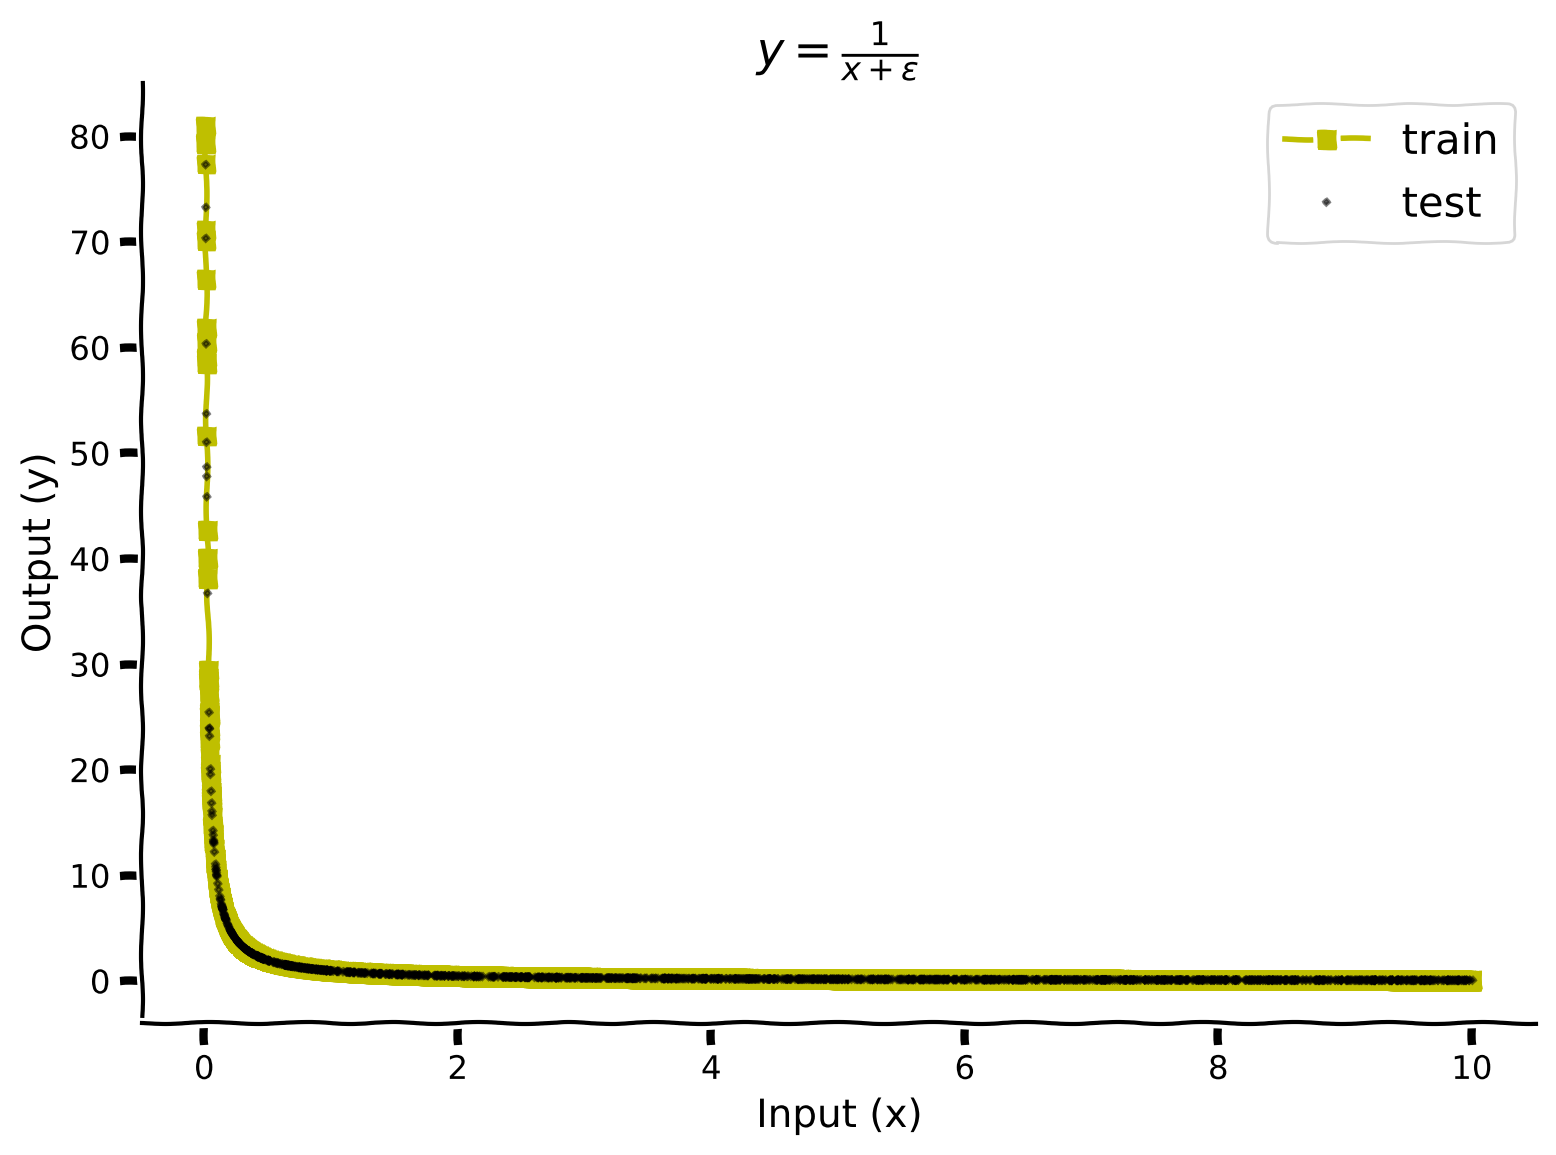

In [7]:
# @title Generate $y=\frac{1}{x+\epsilon}$ train and test dataloaders
# Target function y = 1/x+ε

# @markdown $\epsilon = 0.01$

N_SAMPLES = 5000
X_LOW = 0
X_HIGH = 10
TRAIN_RATIO = 0.7
EPSILON = 1e-2

range01_ratio = 0.20 # % of samples in the range 0-1
X1 = torch.distributions.uniform.Uniform(X_LOW, 1).rsample(sample_shape=torch.Size([int(N_SAMPLES*range01_ratio), 1]))
X2 = torch.distributions.uniform.Uniform(1, X_HIGH).rsample(sample_shape=torch.Size([int(N_SAMPLES*(1-range01_ratio)), 1]))
X_sec1 = torch.concatenate((X1, X2)) + EPSILON
y_sec1 = 1/X_sec1

class ReLUDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

dataset_sec1 = ReLUDataset(X_sec1, y_sec1)

# Define the sizes for training and testing sets
train_size = int(TRAIN_RATIO * len(dataset_sec1))
test_size = len(dataset_sec1) - train_size

# Split the dataset into training and testing sets
train_dataset_sec1, test_dataset_sec1 = random_split(dataset_sec1, [train_size, test_size])

# Dataloaders
# Create DataLoader for the training set
train_dataloader_sec1 = DataLoader(train_dataset_sec1, batch_size=len(train_dataset_sec1), shuffle=True)

# Create DataLoader for the testing set
test_dataloader_sec1 = DataLoader(test_dataset_sec1, batch_size=len(test_dataset_sec1), shuffle=False)

train_data = torch.column_stack((train_dataset_sec1.dataset.X[train_dataset_sec1.indices], train_dataset_sec1.dataset.y[train_dataset_sec1.indices]))
sorted_indices = torch.argsort(train_data[:, 0])
train_data_sorted = torch.index_select(train_data, 0, sorted_indices)

with plt.xkcd():
    plt.plot(train_data_sorted[:, 0], train_data_sorted[:, 1], 's-y', label='train')
    plt.plot(test_dataset_sec1.dataset.X[test_dataset_sec1.indices], test_dataset_sec1.dataset.y[test_dataset_sec1.indices], 'Dk', label='test', alpha=0.5, markersize=1.5)
    plt.xlabel('Input (x)')
    plt.ylabel('Output (y)')
    plt.title(r'$y=\frac{1}{x+\epsilon}$')
    plt.legend(prop={'size': 15})
    ax = plt.gca()
    for line in ax.get_lines():
      line.set_path_effects([path_effects.Normal()])
    plt.show()

## Coding Exercise 1: ReLUNet
Let's define a simple one-layer neural network using the following equation, with our single scalar input $x$:

$$\hat{y} = \sum_{i}w_{i} \text{ReLU}(\theta_{i} - x)$$

Here $\theta_{i}$ is the threshold, and $w_{i}$ is the slope of neuron $i$. $\theta_{i}$  &  $w_{i}$ are learned parameters. Our network has a total of 100 neurons (the summation and aggregation over index $i$ reflects each of these 100 neurons). Your task is to complete the forward pass of the model.

In [24]:
###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete forward pass.")
###################################################################

class ReLUNet(nn.Module):
  """
  ReLUNet architecture
  The structure is the following:
  y = Σi(wi * ReLU(θi - x))
  """
  # Define the structure of your network
  def __init__(self, n_units):
    """
    Args:
      n_units (int): Number of hidden units

    Returns:
      Nothing
    """
    super(ReLUNet, self).__init__()
    # Create input thresholds
    self.input_threshold_weights = nn.Parameter(torch.abs(torch.randn(n_units)))
    self.non_linearity = nn.ReLU()
    self.output_layer = nn.Linear(n_units, 1)
    nn.init.xavier_normal_(self.output_layer.weight)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    op = self.input_threshold_weights- x #prepare the input to be passed through ReLU
    op = self.non_linearity(op) #apply ReLU
    op = self.output_layer(op) #run through output layer
    return op

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    output = self.forward(x)
    return output

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D5_Microcircuits/solutions/W1D5_Tutorial2_Solution_b46035c9.py)



Now, let's train the model and evaluate it.

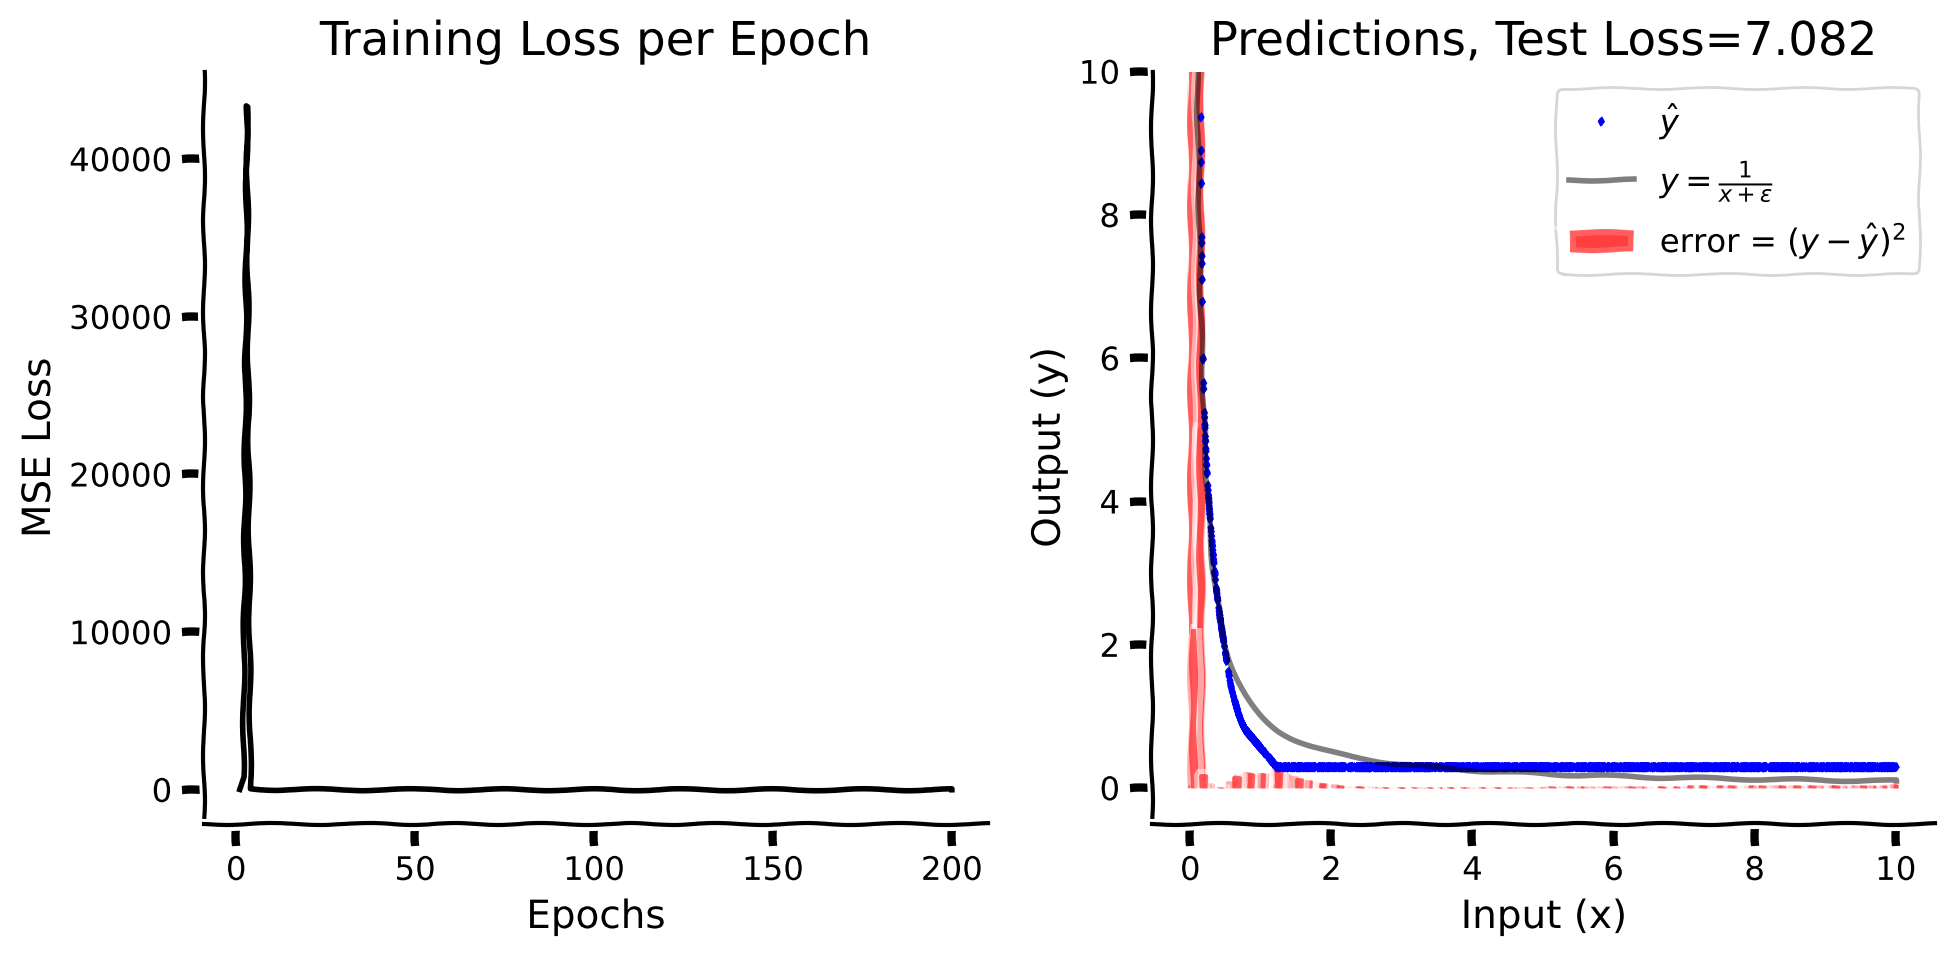

In [28]:
# @title Training & Evaluating model

# Variables
# Model
# Training
n_epochs = 200
learning_rate = 5e-2

# Create a new ReLUNet and transfer it to the device
model = ReLUNet(1000).to(DEVICE)

# Train ReLUNet
losses_iter, losses_epoch, training_dynamics_mat, \
    input_thresholds_tensor, output_weights_tensor = train_sec1(model, \
    train_dataloader_sec1, learning_rate, n_epochs, VAL_X_LOW, VAL_X_HIGH)

# Evaluate ReLUNet
test_loss, x_all, y_all, y_pred_all = evaluate_sec1(model, test_dataloader_sec1)

with plt.xkcd():
    # Plot training and evaluation performance
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Plot training loss per epoch
    ax[0].plot(range(1, len(losses_epoch)+1), losses_epoch, '-k')
    # plot settings
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('MSE Loss')
    ax[0].set_title('Training Loss per Epoch')

    # Plotting evaluation performance
    # plot errors
    y_errs = nn.functional.mse_loss(y_pred_all, y_all, reduction='none')
    ax[1].bar(x_all, y_errs, width=0.1, color='red', alpha=0.5, \
              label='error = $(y - \^y)^{2}$')
    # plot predicted values
    eval_plot_data = torch.column_stack((x_all, y_all, y_pred_all)) # Sort data for plotting
    sorted_indices = torch.argsort(eval_plot_data[:, 0])
    eval_plot_data_sorted = torch.index_select(eval_plot_data, 0, sorted_indices)
    ax[1].plot(eval_plot_data_sorted[:, 0], eval_plot_data_sorted[:, 2], 'db', label=r'$\^y$', markersize=1.5)
    # plot ground truth
    x_values = np.linspace(X_LOW+1e-2, X_HIGH+1e-2, 1000)
    y_values = 1 / x_values
    # plot settings
    ax[1].plot(x_values, y_values, '-k', alpha=0.5, label=r'$y=\frac{1}{x+\epsilon}$')
    ax[1].set_title(f'Predictions, Test Loss={test_loss:.3f}')
    ax[1].set_ylim((-0.5, 10))
    ax[1].set_xlabel('Input (x)')
    ax[1].set_ylabel('Output (y)')
    ax[1].legend()
    plt.tight_layout()
    ax = plt.gca()
    for line in ax.get_lines():
      line.set_path_effects([path_effects.Normal()])
    plt.show()

While the model learns, we see that it does not fit the test data well. Let's find out where the model struggles during training.

Here, we plot the log mean-squared errors for values of $x$ between 0 and 1 and their progression with epochs. These are log errors (clipped at $e^{5}$ represented with blue color).

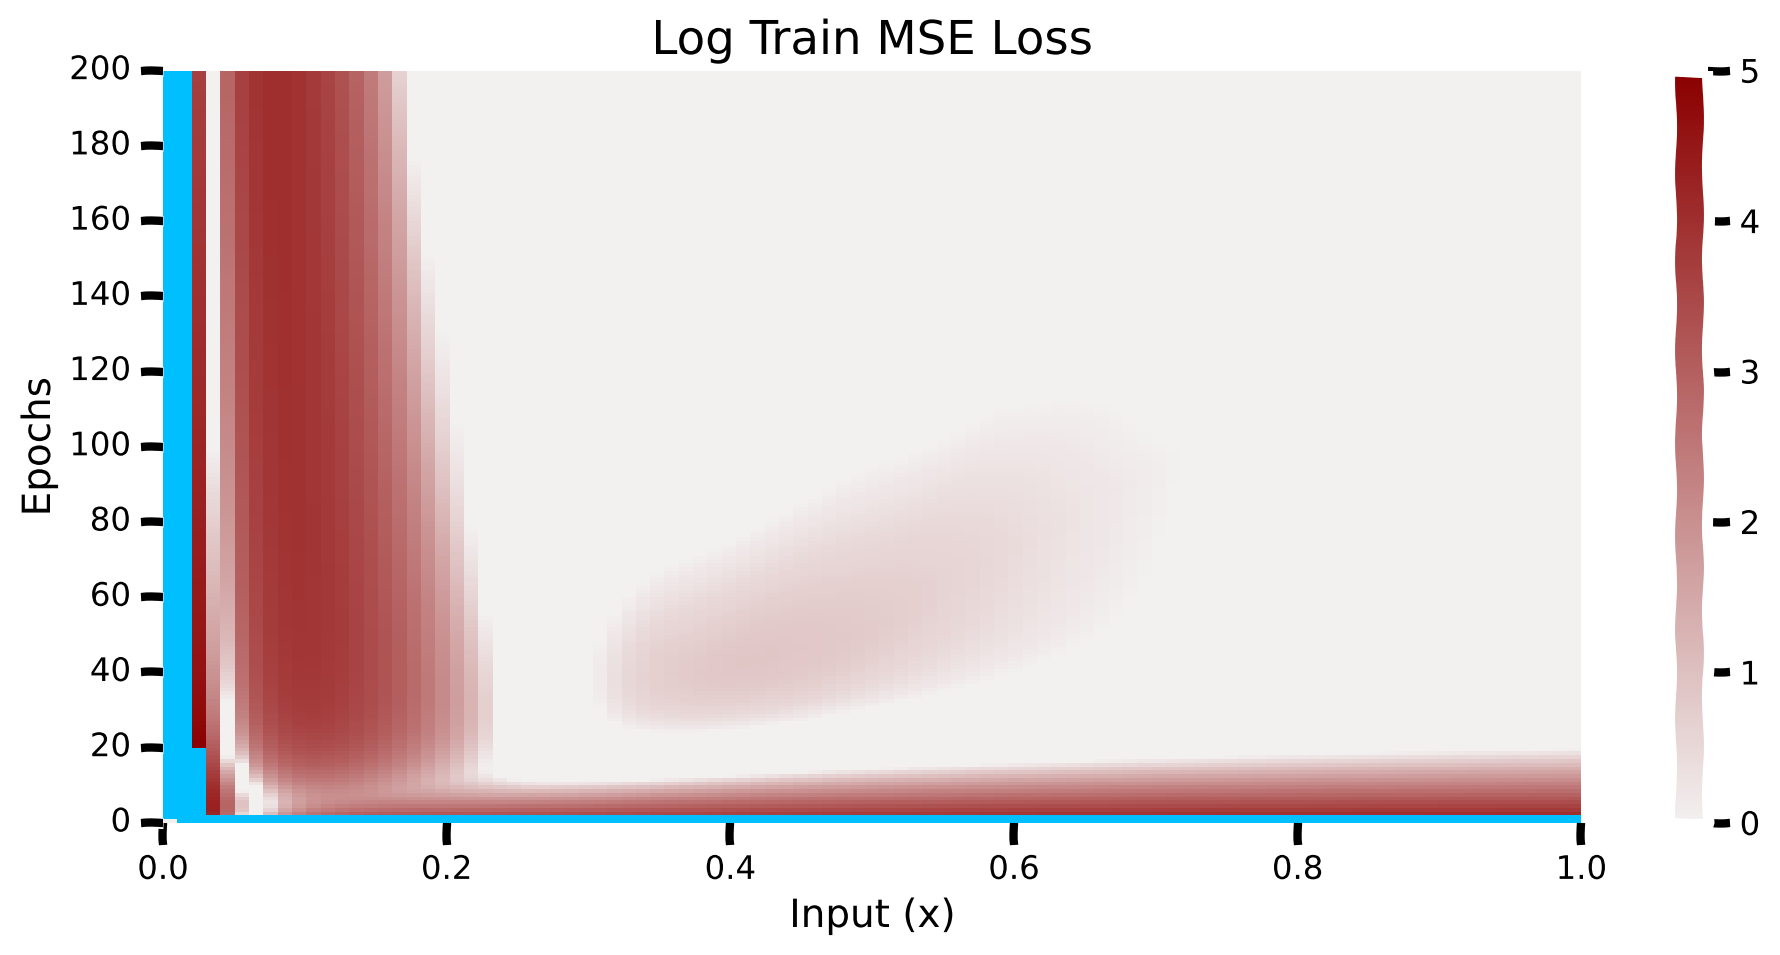

In [29]:
# @title Plot Training Loss Dynamics

MAX_CLIP = 5

with plt.xkcd():
    plt.figure(figsize=(10, 5))

    # Create a custom colormap for clipping
    light_pal = sns.light_palette("darkred", as_cmap=True)
    clipping_color = [0., 0.75, 1., 1.] # RGBA
    new_colors = np.vstack( (light_pal(np.arange(light_pal.N)), np.array([clipping_color])) )
    custom_cmap = sns.blend_palette(new_colors, as_cmap=True)

    ax = sns.heatmap(training_dynamics_mat.numpy(), vmax=MAX_CLIP, vmin = 0, cmap=custom_cmap)

    xptslen = training_dynamics_mat.shape[1]
    xticklabels = np.round(np.arange(VAL_X_LOW, VAL_X_HIGH + 0.05, 0.2), decimals=1)
    ax.set_xticks(np.linspace(0, xptslen, len(xticklabels)), labels=xticklabels)
    ax.set_yticks(np.arange(0, n_epochs+.1, 20), labels=np.arange(n_epochs, -0.1, -20, dtype=int))
    ax.set_xlabel('Input (x)')
    ax.set_ylabel('Epochs')
    plt.title('Log Train MSE Loss')
    plt.show()

We can see that the model has higher errors for lower values of $x$, and as the training progresses, the errors for lower $x$ values start to decrease. Note that the losses are huge for very small values of $x$ ($> e^5$).

Does it mean the model employs more resources to learn the function between 0 and 1? To check this out, let's visualize the ReLU thresholds. Concretely, let's look at the theta values representing the 100 neurons in our one-layer neural network. This will allow us to see where the model is placing most of the emphasis in order to learn the target function.

If you're unsure about the terminology being used (threshold and ReLU value) then it's useful to remember that a neural network is modelled by weights and biases (slopes and intercepts). Each layer of a neural network has an associated slope/weight which is combined with the input value and is then added to a bias (intercept) which then goes through the nonlinearity (ReLU here). The red lines in the figure below represent the bias/intercept values, while the teal lines represent the slopes/weights.

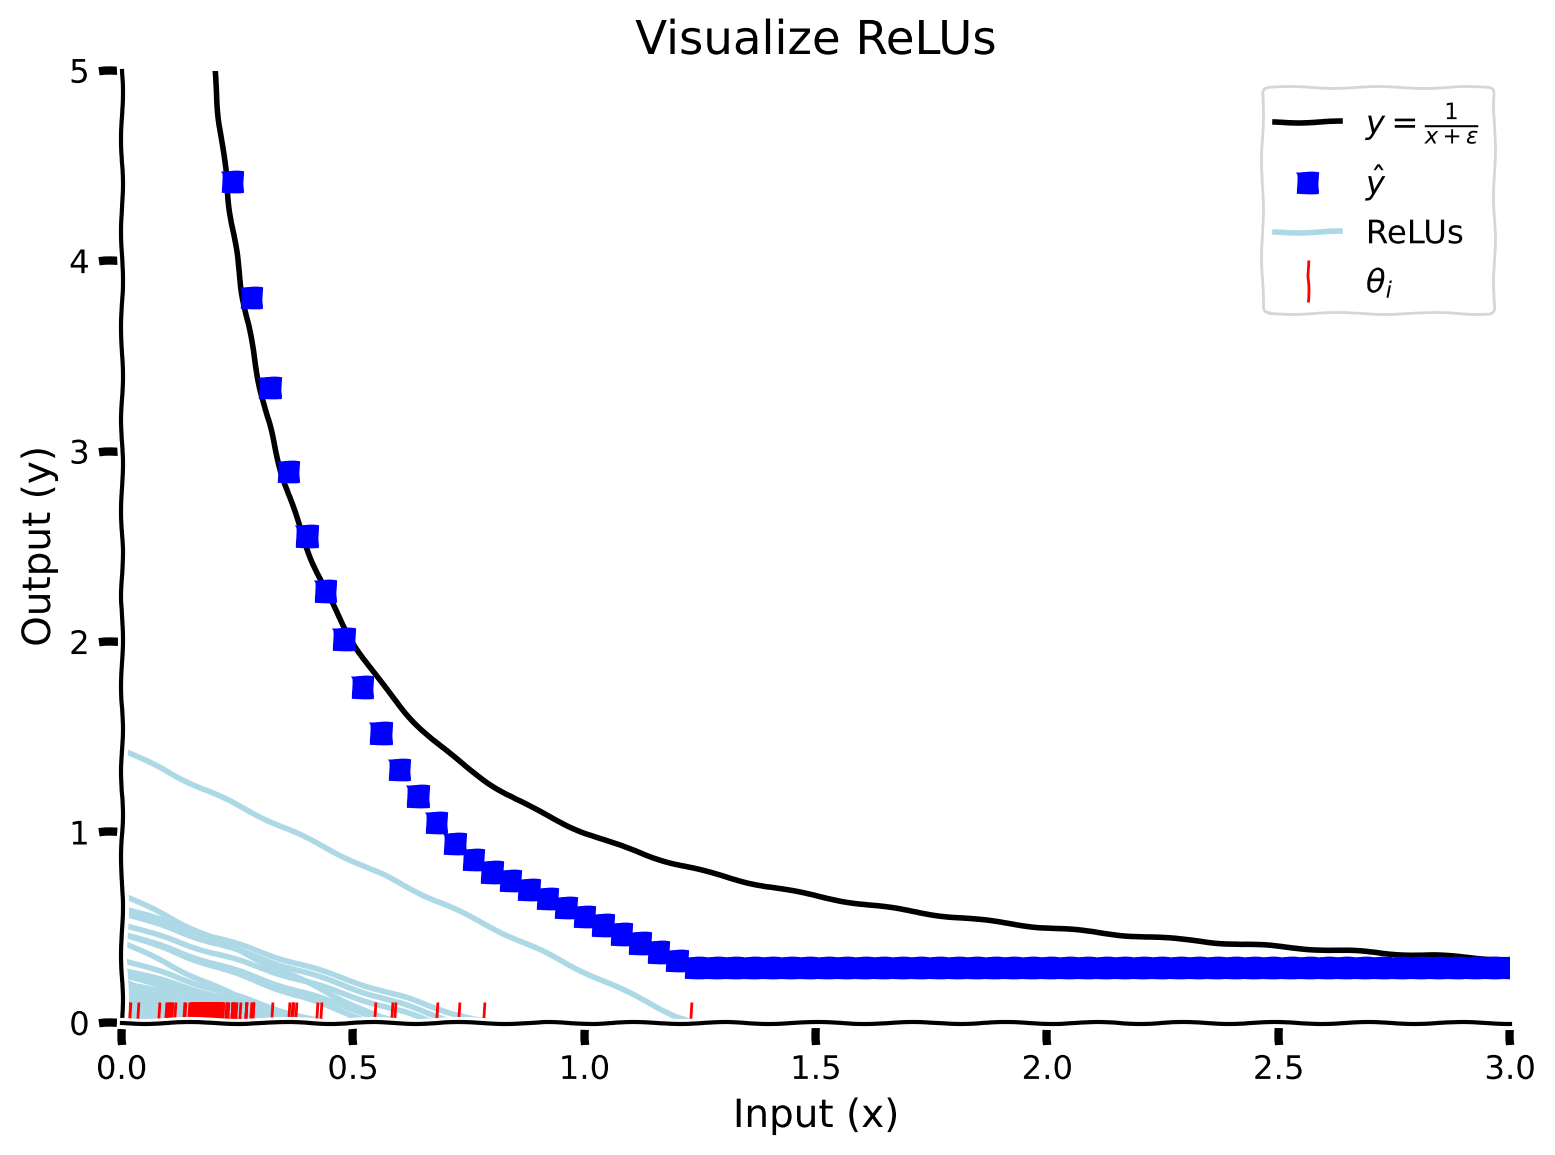

In [32]:
# @title Vizualize ReLUs
# Get model weights
l1_thresholds = model.input_threshold_weights.data.cpu()
l2_slopes = model.output_layer.weight.data[0].cpu()
l2_bias = model.output_layer.bias.item()

# Visualizing
# X points
# 1 * n_samples
xpoints = torch.arange(-5, X_HIGH, 0.04).unsqueeze(1)
# zi = thetai - x
# n_samples * n_units
thetai = l1_thresholds.repeat(len(xpoints), 1)
# n_samples * n_units
zi = thetai - xpoints
# n_samples * n_units
hi = torch.maximum(zi, torch.tensor(0, dtype=torch.float32))
# n_samples * n_units
ahi = hi * l2_slopes
# y = Σi(ahi)
y_pred = torch.sum(ahi, axis=1) + l2_bias

with plt.xkcd():
    # Visualizing
    plt.title(f'Visualize ReLUs')

    # y =1/x
    # Generate x values in the range [X_LOW, X_HIGH]
    x_values = np.linspace(X_LOW+1e-2, X_HIGH+1e-2, 1000)
    # Calculate y values for the function y = 1/x
    y_values = 1 / x_values
    plt.plot(x_values, y_values, '-k', alpha=1, label=r'$y=\frac{1}{x+\epsilon}$')

    # x = 0
    # plt.axvline(x=0, c='k',label='x=0')

    # y_hat
    plt.plot(xpoints, y_pred, 'sb', markersize=7, label=r'$\^y$')

    # ReLUs
    for i in range(ahi.shape[-1]):
      plt.plot(xpoints, ahi[:, i], '-', alpha=1, color='lightblue')
    plt.plot([], [], '-', label='ReLUs', color='lightblue')

    # Thresholds
    plt.plot(l1_thresholds, np.zeros(len(l1_thresholds)), '|r', \
             markersize=15, label=r'$\theta_{i}$')

    plt.xlabel('Input (x)')
    plt.ylabel('Output (y)')
    plt.ylim((0, 5))
    plt.xlim((0, 3))
    plt.legend()
    ax = plt.gca()
    for line in ax.get_lines():
      line.set_path_effects([path_effects.Normal()])
    plt.show()

We can see that the thresholds (red lines) are bunched up between 0 and 1, which means that the model dedicates the most resources to learning the function on this interval. Let's quantify the learning by plotting the threshold distributions and dynamics with epochs.

Here we plot the cumulative distributions of $\theta_{i}$ & $w_{i}$. We also plot the values of the parameters as they change across epochs.

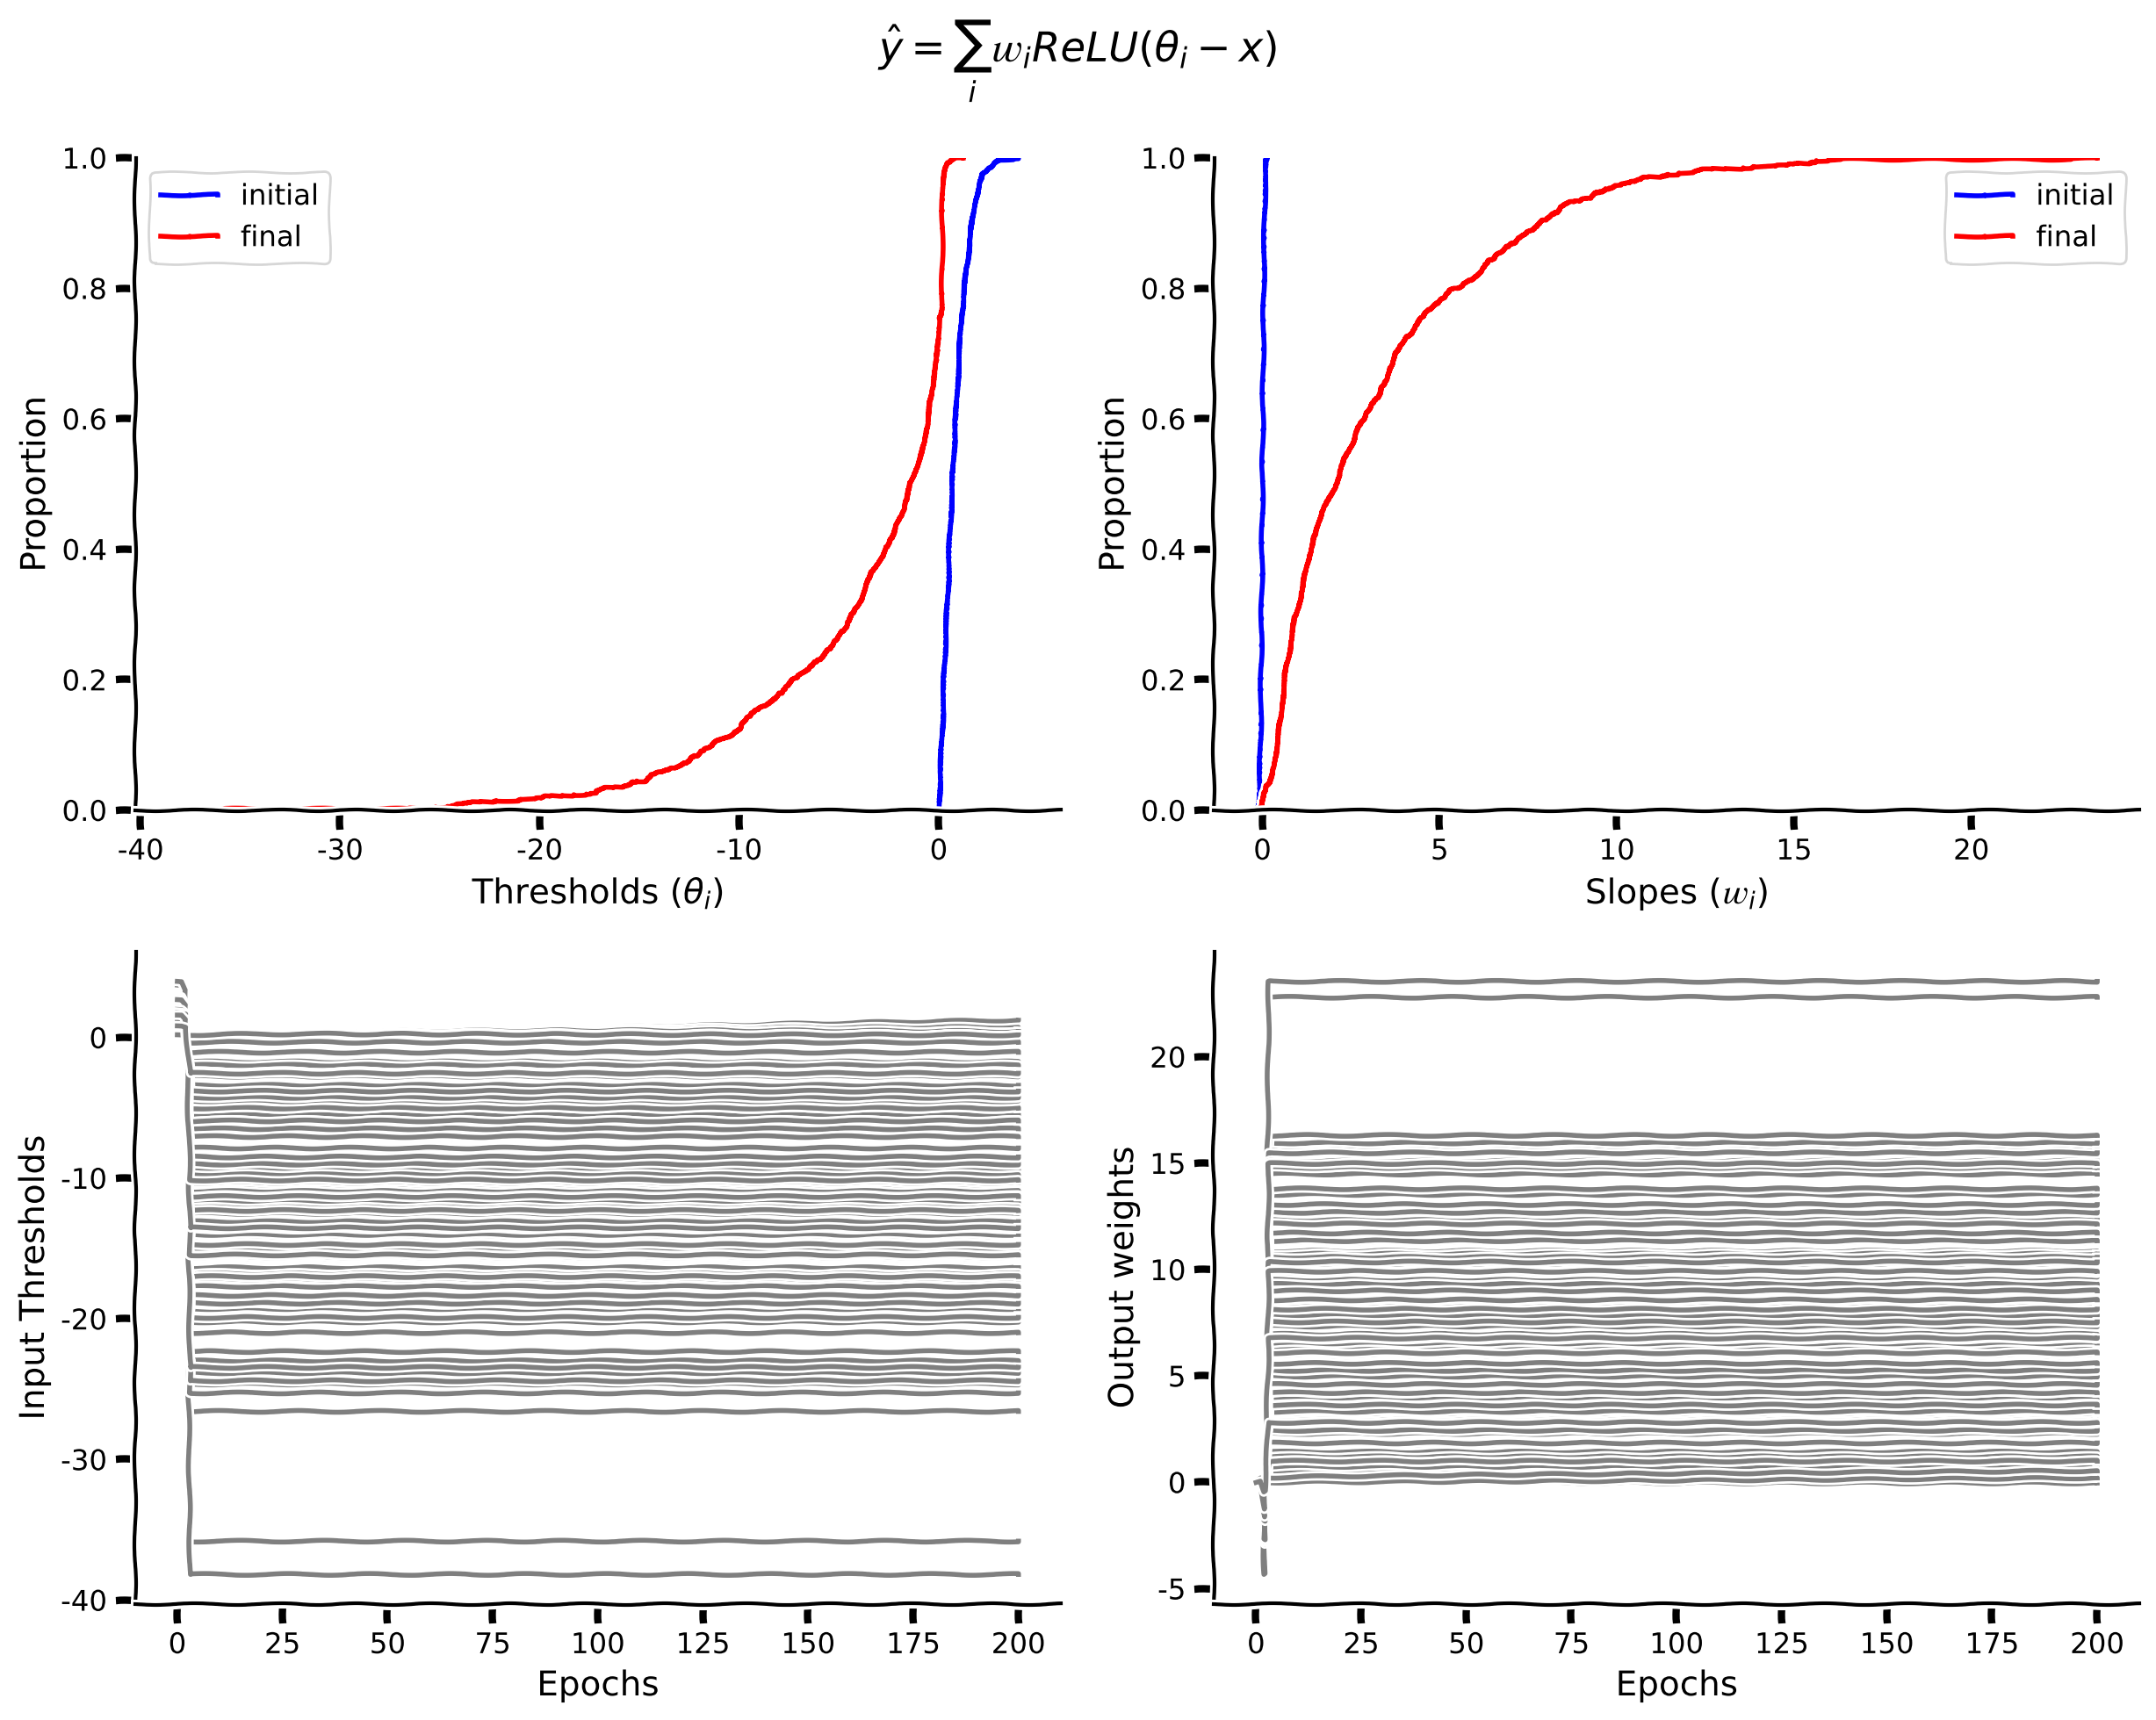

In [31]:
# @title Plot Weight Dynamics

with plt.xkcd():
    fig, ax = plt.subplots(2, 2, figsize=(12.5,10))
    ax[0, 0].set_xlabel(r'Thresholds ($\theta_{i}$)')
    thereshold_weights = model.input_threshold_weights.data.cpu()
    sns.ecdfplot(input_thresholds_tensor[0, :], color='b', ax=ax[0, 0], label='initial')
    sns.ecdfplot(thereshold_weights, color='r', ax=ax[0, 0], label='final')
    ax[0, 0].legend()
    ax[0, 1].set_xlabel('Slopes ($𝑤_{i}$)')
    slopes = model.output_layer.weight.data[0].cpu()
    sns.ecdfplot(output_weights_tensor[0, :], color='b', ax=ax[0, 1], label='initial')
    sns.ecdfplot(slopes, color='r', ax=ax[0, 1], label='final')
    fig.suptitle(r'$\hat{y} = \sum_{i}𝑤_{i} ReLU(\theta_{i} - x)$')
    ax[0, 1].legend()

    # Input thresholds
    n_cols = input_thresholds_tensor.shape[-1]
    n_rows = input_thresholds_tensor.shape[0]
    for n_col in range(n_cols):
      ax[1, 0].plot(range(n_rows), input_thresholds_tensor[:, n_col], '-k', alpha=0.5)
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('Input Thresholds')
    # Output weights
    n_cols = output_weights_tensor.shape[-1]
    n_rows = output_weights_tensor.shape[0]
    for n_col in range(n_cols):
      ax[1, 1].plot(range(n_rows), output_weights_tensor[:, n_col], '-k', alpha=0.5)
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Output weights')
    plt.tight_layout()
    plt.show()

From the cumulative distribution plot of the thresholds ($\theta_{i}$), we can see that around $80%$ of them are below $x=1$. Hence, the model majorly struggles to learn the function between 0 and 1, where the slope changes a lot.

Since the slope changes infinite times between $x=0$ and 1, and ReLUs implement a linear function with a single slope, we would ideally need an infinite number of ReLUs units to fit the $y=\frac{1}{x+\epsilon}$ function. Hence, even though theoretically we can estimate the function, it is not empirically feasible to do so. This suggests that a microcircuit able to implement this computation would be a very useful thing to have.

### Coding Exercise 1 Discussion

1. Do you think that having more slope changes in the activation function would help?

Take a minute to think on your own, then discuss in a group.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_relunet")

## Coding Exercise 2: Test other non-linear activation functions

Let's see if other non-linear activation functions perform better. Specifically, we test:
1. $\text{ReLU}(x) = (x)^{+} = \max(0,x)$
2. $\text{ReLU6}(x) = \min(\max(0,x),6)$
3. $\text{SoftPlus}(x, \beta=1) = \frac{1}{\beta} \log(1+e^{βx})$
4. $\text{Sigmoid}(x) = \sigma(x)= \frac{1}{1+e^{-x}}$
5. $\text{Tanh}(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$

We still consider the case of the one-layer neural network, except we change the activation function to be one of the above:

$$\hat{y} = \sum_{i}w_{i} \text{Activation}(\theta_{i} - x)$$

Here $\theta_{i}$ is the threshold, and $w_{i}$ is the slope of neuron $i$. We train and evaluate each model three times and plot the mean performance across runs in order to make sure our results are not highly dependent on any specific initialization setting of the network. Your task is to complete the dictionary of the proposed non-linear functions (by defining them using `torch.nn` library).

In [35]:
###################################################################
## Fill out the following then remove
# raise NotImplementedError("Student exercise: complete non-linearities.")
###################################################################
non_linearities = {
    'ReLU': nn.ReLU(),
    'ReLU6': nn.ReLU6(),
    'SoftPlus': nn.Softplus(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D5_Microcircuits/solutions/W1D5_Tutorial2_Solution_a36a7d90.py)



Now, let's train different networks and evaluate them. Notice that the cell below will run for 1 minute approximately.

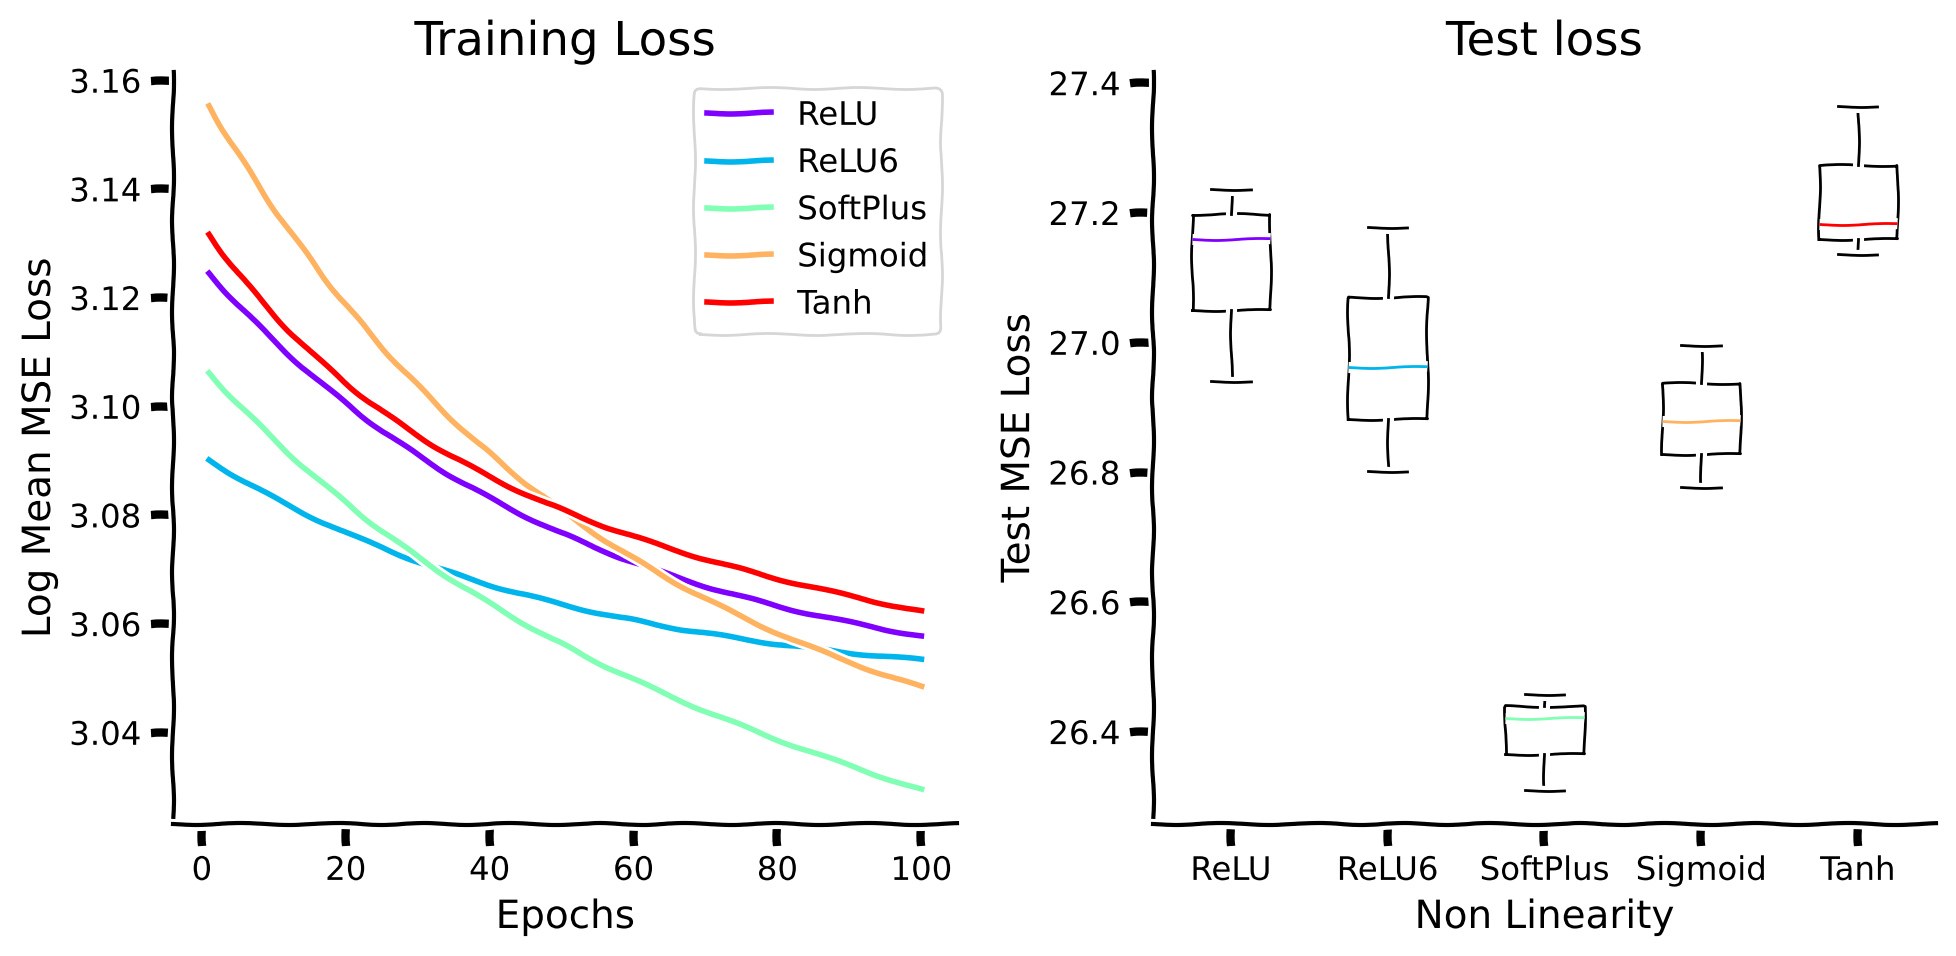

In [36]:
# @title Train & Evaluate

class NonLinearNet(nn.Module):
  """
  NonLinearNet architecture
  The structure is the following:
  y = Σi(ai * Non-Linearity(θi - x))
  """
  # Define the structure of your network
  def __init__(self, n_units, non_linearity):
    """
    Args:
      n_units (int): Number of hidden units

    Returns:
      Nothing
    """
    super(NonLinearNet, self).__init__()
    self.n_units = n_units
    self.input_threshold_weights = nn.Parameter(torch.normal(0., 0.1, (self.n_units,)))
    self.non_linearity = non_linearity
    self.output_layer = nn.Linear(n_units, 1)
    nn.init.normal_(self.output_layer.weight, mean=0, std=0.1)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    # Threshold
    op = self.input_threshold_weights - x
    op = self.non_linearity(op)
    op = self.output_layer(op)
    return op

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Args:
      x: torch.Tensor
        Input tensor of size ([1])
    """
    output = self.forward(x)
    return output

# Model
n_units = 1

# Training
n_epochs = 100
learning_rate = 5e-3

# Experiment
n_runs = 3

nls_train_loss_epochs = {}
nls_test_losses = {}

for n_run in range(n_runs):
  for nl_name, nl in non_linearities.items():
    model = NonLinearNet(n_units, nl).to(DEVICE)
    losses_iter, losses_epoch, training_dynamics_mat, \
        input_thresholds_tensor, output_weights_tensor = train_sec1(model, \
        train_dataloader_sec1, learning_rate, n_epochs, VAL_X_LOW, VAL_X_HIGH)
    if nl_name in nls_train_loss_epochs.keys():
      nls_train_loss_epochs[nl_name] = np.vstack((nls_train_loss_epochs[nl_name], np.array(losses_epoch)))
    else:
      nls_train_loss_epochs[nl_name] = np.array(losses_epoch)

    test_loss, x_all, y_all, y_pred_all = evaluate_sec1(model, test_dataloader_sec1)
    if nl_name in nls_test_losses.keys():
      nls_test_losses[nl_name].append(test_loss.item())
    else:
      nls_test_losses[nl_name] = [test_loss.item()]

with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Plot Training loss
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(nls_train_loss_epochs))))
    for nl_ in non_linearities.keys():
      c = next(colors)
      mean_train_loss = np.mean(nls_train_loss_epochs[nl_], axis=0)
      mean_train_loss = np.log(mean_train_loss)
      ax[0].plot(range(1, len(mean_train_loss)+1), mean_train_loss, '-', color=c, label=nl_)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Log Mean MSE Loss')
    ax[0].legend()
    ax[0].set_title('Training Loss')

    # Plot loss per epoch
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(nls_train_loss_epochs))))
    box = ax[1].boxplot(list(nls_test_losses.values()), showfliers=False, \
                        medianprops={'color':'gray'})
    for median in box['medians']:
      c = next(colors)
      median.set_color(c)
    # plt.ylim((-0.5, 5))
    ax[1].set_xticks(range(1, len(nls_test_losses)+1), labels=nls_test_losses.keys())
    ax[1].set_xlabel('Non Linearity')
    ax[1].set_ylabel('Test MSE Loss')
    ax[1].set_title('Test loss')
    plt.tight_layout()
    plt.show()

We can see that all of the proposed non-linear activation functions do not perform very well. Hence, it is beneficial to have dedicated computation that implements normalization.

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_nonlinear_activation_functions")

In [ ]:
# @title Video 2: Summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'PrkBtUdXEEM'), ('Bilibili', 'BV1Ff421Q7oC')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_first_section_summary")

---
# Section 2: Benefits of normalization

*Estimated timing to here from start of tutorial: 20 minutes.*

In this section, we will propose a simple normalization function, which you are going to test in different environments and observe how it is connected to the concept of generalization, the overarching theme of this entire course.

In [ ]:
# @title Video 3: Introduction to Normalization

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'i9cPx6jt590'), ('Bilibili', 'BV1zn4y197yW')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_introduction_to_normalization")

---
## Subsection 2.1: Explore normalization

This subsection is devoted to the definition of simple normalization function and the exploration of hyperparameters' impact on its result.

### Coding Exercise 2.1: Implement normalization

Let's implement the normalization we saw in the video above. Specifically, we will use the following function:

$$\mathbf{x}_{norm} = \frac{g \mathbf{x}}{\sigma + \sqrt[p]{\Sigma_{i = 1}^{N} |x_{i}|^{p}}}$$

Where

- $x$ is an $N$-dimensional vector ($x \in \mathbb{R}^N$),

- $g$ is a scaling factor,

- $\sigma$ is a smoothing (translation) factor,

- $p$ defines $p$-norm of the input vector (e.g. if $p=2$ this is an $L2$ norm)

Note that we are normalizing across dimensions (similar to Layer Normalization).

You can test your implementation by running the code cell below!

In [58]:
def normalize(x, sigma, p, g):
  """
  Inputs:
  - x(np.ndarray): Input array (n_samples * n_dim)
  - sigma(float): Smoothing factor
  - p(int): p-norm
  - g(int): scaling factor

  Outputs:
  - xnorm (np.ndarray): normalized values.
  """
  #################################################
  ## TODO: Implement the normalization example equation ##
  # Fill remove the following line of code once you have completed the exercise:
  # raise NotImplementedError("Student exercise: complete normalization function.")
  #################################################
  # Raise the absolute value of x to the power p
  xp = np.power(np.abs(x), p)
  # Sum the x over the dimensions (n_dim) axis
  xp_sum = np.sum(xp, axis =1)
  # Correct the dimensions of xp_sum, and taking the average reduces the dimensions
  # Making xp_sum a row vector of shape (1, n_dim)
  xp_sum = np.expand_dims(xp_sum, axis=1)
  # Raise the sum to the power 1/p and add the smoothing factor (sigma)
  denominator = np.power(xp_sum, 1/p) + sigma
  # Scale the input data with a factor of g
  numerator = g * x
  # Calculate normalized x
  xnorm = numerator/denominator
  return xnorm

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D5_Microcircuits/solutions/W1D5_Tutorial2_Solution_dd43ccaf.py)



In [52]:
# @markdown Test `normalize()` function
def check_normalize(func):
  def np_norm(x, sigma, p, g):
    xnorm = (x*g)/(np.expand_dims(np.linalg.norm(x, ord=p, axis=1), axis=1)+sigma)
    return xnorm
  # Function to check the normalization function
  incorrect_message = "Normalize function incorrect"
  test_x = np.random.rand(3, 3)
  # Test 1
  assert np.array_equal(np_norm(test_x, 1, 1, 1), normalize(test_x, 1, 1, 1)), incorrect_message
  # Test 2
  assert np.array_equal(np_norm(test_x, 2, 0.3, 1.2), normalize(test_x, 2, 0.3, 1.2)), incorrect_message
  # Test 3
  assert np.array_equal(np_norm(test_x, 0.1, 3, 2), normalize(test_x, 0.1, 3, 2)), incorrect_message
  # Test 4
  assert np.array_equal(np_norm(test_x, 2.4, 3.2, 1.5), normalize(test_x, 2.4, 3.2, 1.5)), incorrect_message
  print('Normalize function works correctly!')

check_normalize(normalize)

Normalize function works correctly!


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_implement_normalization")

### Interactive Demo 2.1

Let's explore the effect of smoothing factor ($\sigma$), p-norm ($p$) and scaling factor ($g$) in our normalization function:

$$\mathbf{x}_{norm} = \frac{g \mathbf{x}}{\sigma + \sqrt[p]{\Sigma_{i = 1}^{N} |x_{i}|^{p}}}$$

We will see the effect of normalization being induced on the points sampled from a 2-dimensional normal distribution.

Take a minute to play around with the values and then discuss them in the group.

In [59]:
# @title Effect of smoothing factor ($\sigma$), p-norm ($p$) and scaling factor ($g$)

n_points = 1000
n_dim = 2
x_sec21 = np.random.normal(loc=0.0, scale=0.5, size=(n_points, n_dim))

@widgets.interact(sigma=widgets.FloatSlider(0.1, min=0, max=2, description='σ', layout=widgets.Layout(width='50%')),\
                  p=widgets.FloatSlider(1, min=0.1, max=5, description=r'p', layout=widgets.Layout(width='50%')), \
                  g=widgets.FloatSlider(1, min=0.1, max=2, description='g', layout=widgets.Layout(width='50%')))
def visualize_normalization(sigma, p, g):
  x_ = normalize_implemented(x_sec21, sigma, p, g)
  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(5, 5))

  # Set the spines (axes lines) to intersect at the center
  ax.spines['left'].set_position('zero')
  ax.spines['bottom'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  # Set the ticks
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')

  # Bold ticks
  for tick in ax.get_xticklabels():
      tick.set_fontweight('bold')
  for tick in ax.get_yticklabels():
      tick.set_fontweight('bold')

  ax.plot(x_sec21[:, 0], x_sec21[:, 1], '.b', markersize=5, alpha=0.5, label='Original')
  ax.plot(x_[:, 0], x_[:, 1], '.r', markersize=5, alpha=0.75, label='Normalized')
  ax.set_xlabel('$x_{1}$', loc='right', fontsize=20, fontweight='bold')
  ax.set_ylabel('$x_{2}$', loc='top', rotation=0, fontsize=20, fontweight='bold')
  ax.set_xlim((-2, 2))
  ax.set_ylim((-2, 2))
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=0.1, description='σ', layout=Layout(width='50%'), max=2.0), FloatSlide…

In [ ]:
# @title Video 4: Effect of smoothing factor, p-norm and scaling factor

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'v8lubAW9GKk'), ('Bilibili', 'BV1Ns421u7Lt')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_hyperparameters_impact")

---
## Subsection 2.2: Estimating latent properties

In this subsection, we will use the normalization function to retrieve the target variable being corrupted with scaling.

In [ ]:
# @title Video 5: Normalization example

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'RiNXyNqH9YI'), ('Bilibili', 'BV1RJ4m1g7t4')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_normalization_example")

### Interactive Demo 2.2.1

For this demo, we have a target image ($\mathbf{x}$), which we would like to infer, and a visible image ($\mathbf{v}$), which is a scaled version of the target one: $\mathbf{x} = s \mathbf{v}$. We will generate 300 different examples (we will visualize only 25 of them) of 5-dimensional vectors $\mathbf{x}$ (each of the components of the vectors is generated from an exponential distribution with $\lambda = 1$). Then, the scaling factor $s$ is generated from an exponential distribution with $\lambda = 1$ as well.

Play around with different hyperparameter values to get the best R-squared value.

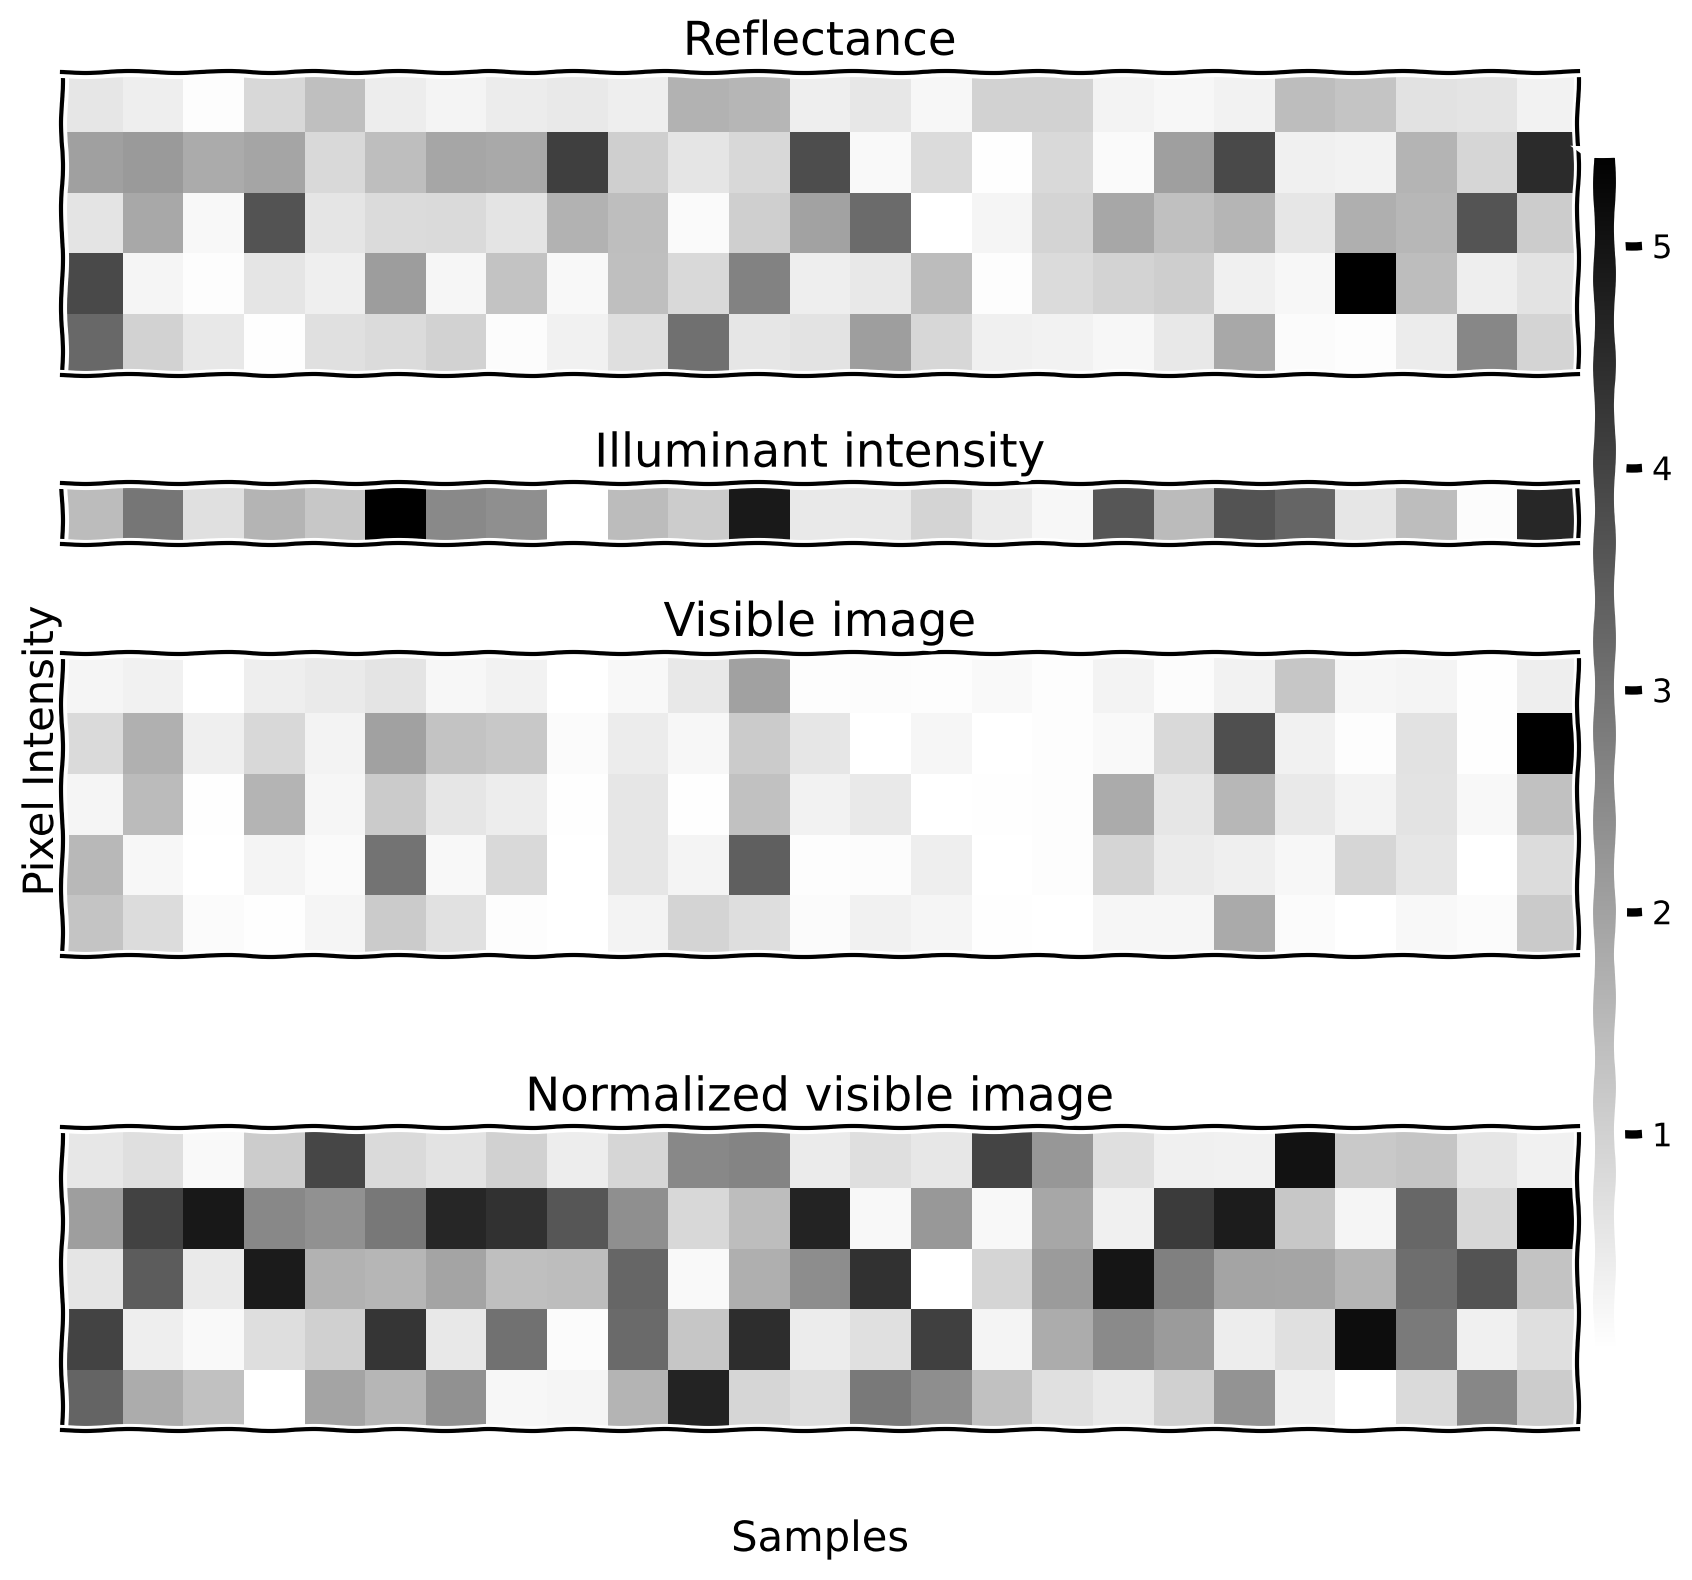

In [61]:
number_samples = 300 # Number of samples
number_pixels = 5 # Number of pixels per sample

# True reflectance
reflectance = np.random.exponential(1, size=(number_samples, number_pixels))
# Illuminant intensity
illuminant_intensity = np.random.exponential(1, size=(number_samples, 1))
# Visible image
visible_image = np.repeat(illuminant_intensity, number_pixels, axis=1) * reflectance

#################################################
## TODO: Implement the normalization example equation ##
# Fill remove the following line of code one you have completed the exercise:
# raise NotImplementedError("Student exercise: choose your parameters values.")
#################################################

# Normalized visible image
norm_visible_image = normalize(
    visible_image,
    sigma = 0.1,
    p = 2,
    g = 2
)

# Visualize the images
visualize_images_sec22(
    [reflectance, illuminant_intensity, visible_image, norm_visible_image],
    ['Reflectance', 'Illuminant intensity', 'Visible image', 'Normalized visible image'],
    25
)

[*Click for solution*](https://github.com/neuromatch/NeuroAI_Course/tree/main/tutorials/W1D5_Microcircuits/solutions/W1D5_Tutorial2_Solution_9b3b7306.py)

*Example output:*

<img alt='Solution hint' align='left' width=846.0 height=790.0 src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D5_Microcircuits/static/W1D5_Tutorial2_Solution_9b3b7306_0.png>



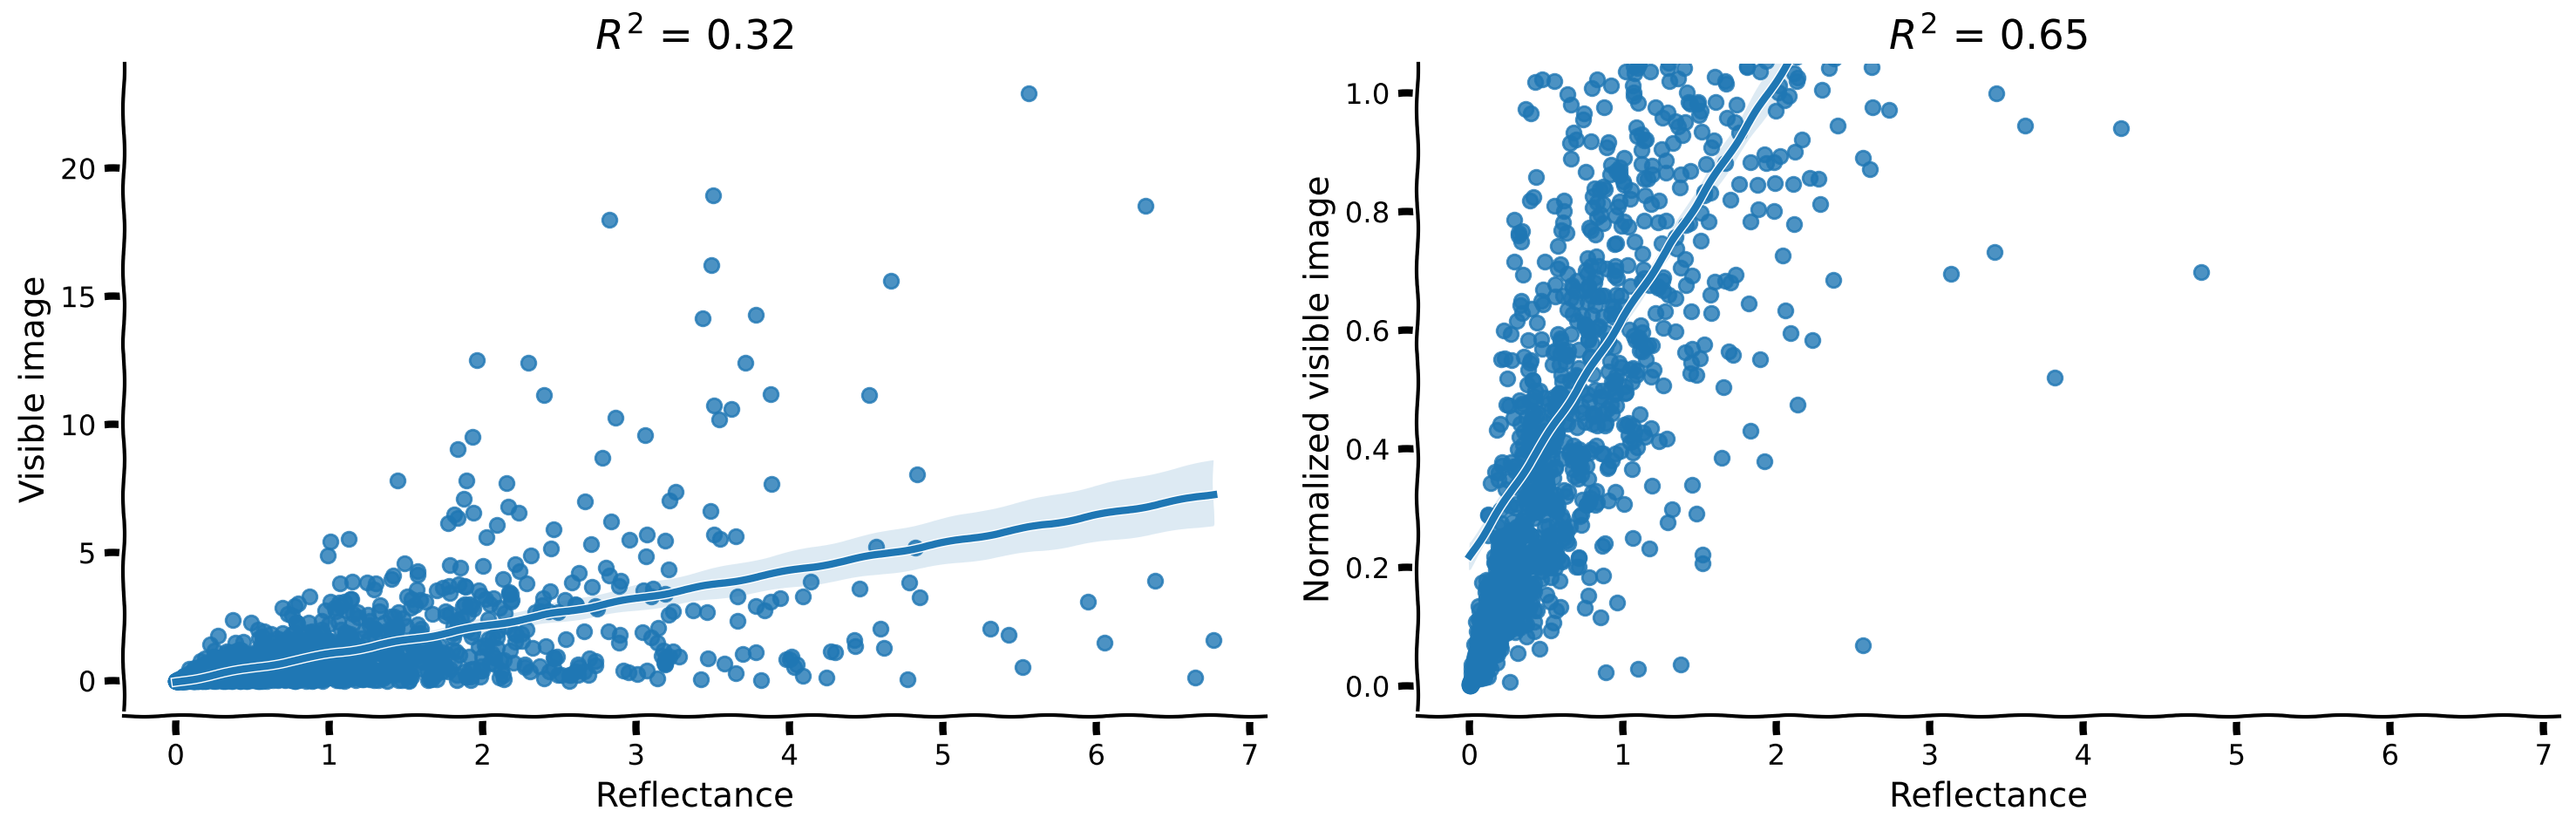

In [62]:
# @title Plot correlation of estimated reflectance with true reflectance

with plt.xkcd():
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Plot v vs. x
    x_ = reflectance.reshape((-1, 1)).squeeze(-1)
    y_ = visible_image.reshape((-1, 1)).squeeze(-1)
    sns.regplot(x=x_, y=y_, ax=ax[0])
    ax[0].set_xlabel('Reflectance')
    ax[0].set_ylabel('Visible image')
    # Calculate R-squared and p-value
    result = scipy.stats.linregress(x_, y_)
    ax[0].set_title(f'$R^{2}$ = {(result.rvalue**2):.2f}')

    # Plot xh vs. x
    x_ = reflectance.reshape((-1, 1)).squeeze(-1)
    y_ = norm_visible_image.reshape((-1, 1)).squeeze(-1)
    sns.regplot(x=x_, y=y_, ax=ax[1])
    ax[1].set_xlabel('Reflectance')
    ax[1].set_ylabel('Normalized visible image')
    ax[1].set_ylim((-0.05, 1.05))
    # Calculate R-squared and p-value
    result = scipy.stats.linregress(x_, y_)
    ax[1].set_title(f'$R^{2}$ = {(result.rvalue**2):.2f}')

    plt.tight_layout()
    plt.show()

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_infer_visible_image")

### Interactive Demo 2.2.2

Now, explore the impact of change in the hyperparemeter values on the R-squared value by using interactive sliders below.

In [63]:
# @title Effect of smoothing factor ($\sigma$), p-norm ($p$) and scaling factor ($g$)
@widgets.interact(sigma=widgets.FloatSlider(0.1, min=0, max=2, description='σ', layout=widgets.Layout(width='50%')),\
                  p=widgets.FloatSlider(1, min=0.1, max=5, description=r'p', layout=widgets.Layout(width='50%')), \
                  g=widgets.FloatSlider(1, min=0.1, max=2, description='g', layout=widgets.Layout(width='50%')))
def plot_correlation_vhat_x(sigma, p, g):
  # Plot xh vs. x
  x_ = reflectance.reshape((-1, 1)).squeeze(-1)
  y_ = normalize_implemented(visible_image, sigma, p, g).reshape((-1, 1)).squeeze(-1)
  sns.regplot(x=x_, y=y_)
  plt.xlabel('Reflectance')
  plt.ylabel('Normalized visible image')
  plt.ylim((-0.05, 1.05))
  # Calculate R-squared and p-value
  result = scipy.stats.linregress(x_, y_)
  plt.title(f'$R^{2}$ = {(result.rvalue**2):.2f}')
  plt.tight_layout()
  plt.show()

interactive(children=(FloatSlider(value=0.1, description='σ', layout=Layout(width='50%'), max=2.0), FloatSlide…

In [ ]:
# @title Video 6: Summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'uEY8s-sxRMA'), ('Bilibili', 'BV1cn4y1X7sF')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_latent_properties_section_summary")

## Subsection 2.3: Layer Normalization

In this subsection, we are going to the explore normalization operation on a real application from the CIFAR10 dataset. This data subset has undergone scaling that we will aim to **correct for**.

In [ ]:
# @title Video 7: Image recognition example

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'vMGOlm94iP0'), ('Bilibili', 'BV1Gz42187yV')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_image_recognition_example")

First, we fetch the dataset and derive only the part corresponding to the following three classes: plane, car, and cat.

In [64]:
# @title Get CIFAR3 scaled and unscaled dataloader

set_seed(seed=42, seed_torch=True)

batch_size = 512

# CIFAR-10 dataset
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((8, 8)),
    transforms.Normalize(
        (0.49139968, 0.48215827, 0.44653124),
        (0.24703233, 0.24348505, 0.26158768))
    ])

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class CIFAR3(torch.utils.data.Dataset):
    def __init__(self, dataset, classes, scale=False, scaling_limits=[0.05, 0.25]):
        self.dataset = dataset
        self.classes = classes

        # Filter indices based on chosen classes
        cls_indices = {}
        subset_ratio = 0.8
        self.indices = []
        for cls, cls_enum in self.classes.items():
          imgs_ = [i for i, label in enumerate(self.dataset.targets) if label == cls]
          self.indices += imgs_[:int(len(imgs_)*subset_ratio)]

        self.scale = scale
        self.scaling_limits = scaling_limits
        if self.scale:
            self.scale_distribution = torch.distributions.Uniform(*self.scaling_limits)
            self.scale_values = self.scale_distribution.sample((len(self.indices),))

    def __getitem__(self, index_cifar3):
        index_cifar10 = self.indices[index_cifar3]
        image, label = self.dataset[index_cifar10]
        label = self.classes[label]
        if self.scale:
            scalar = self.scale_values[index_cifar3]
            image = image * scalar
        return image, label

    def __len__(self):
        return len(self.indices)

cifar3_classes = {
    0: 0, # plane
    1: 1, # car
    3: 2, # cat
}

# CIFAR-10 datasets
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_transform)
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar_transform)

# CIFAR3
cifar3_trainset = CIFAR3(cifar10_trainset, cifar3_classes)
cifar3_trainloader = torch.utils.data.DataLoader(cifar3_trainset, batch_size=batch_size,
                                          shuffle=True)
cifar3_testset = CIFAR3(cifar10_testset, cifar3_classes)
cifar3_testloader = torch.utils.data.DataLoader(cifar3_testset, batch_size=batch_size,
                                         shuffle=False)

# CIFAR3 Scaled
cifar3scaled_trainset = CIFAR3(cifar10_trainset, cifar3_classes, scale=True)
cifar3scaled_trainloader = torch.utils.data.DataLoader(cifar3scaled_trainset, batch_size=batch_size,
                                          shuffle=True)
cifar3scaled_testset = CIFAR3(cifar10_testset, cifar3_classes, scale=True)
cifar3scaled_testloader = torch.utils.data.DataLoader(cifar3scaled_testset, batch_size=batch_size,
                                         shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 46.9MB/s]


Let us take a look at the original (latent) images and their scaled versions.

Labels = car  , plane, car  , car  , cat  , cat  , car  , car  


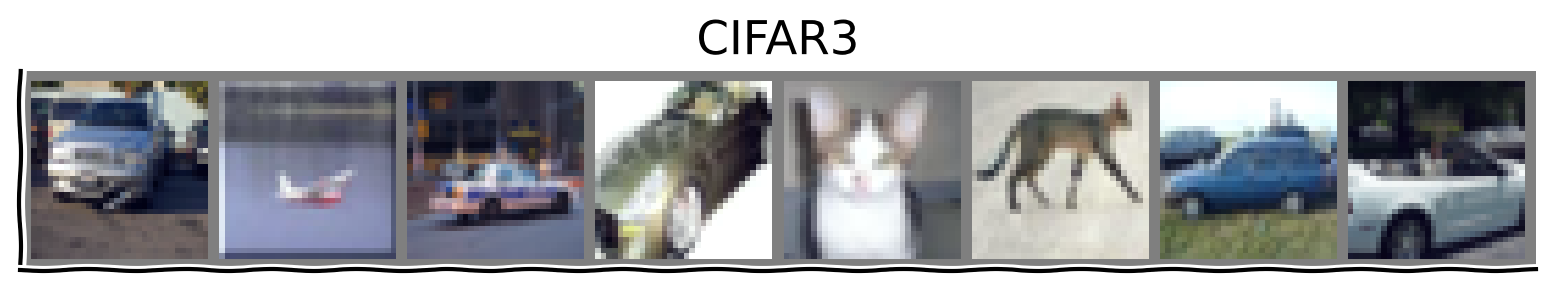

Scaling factors = 0.14, 0.171, 0.224, 0.148, 0.221, 0.179, 0.099, 0.155


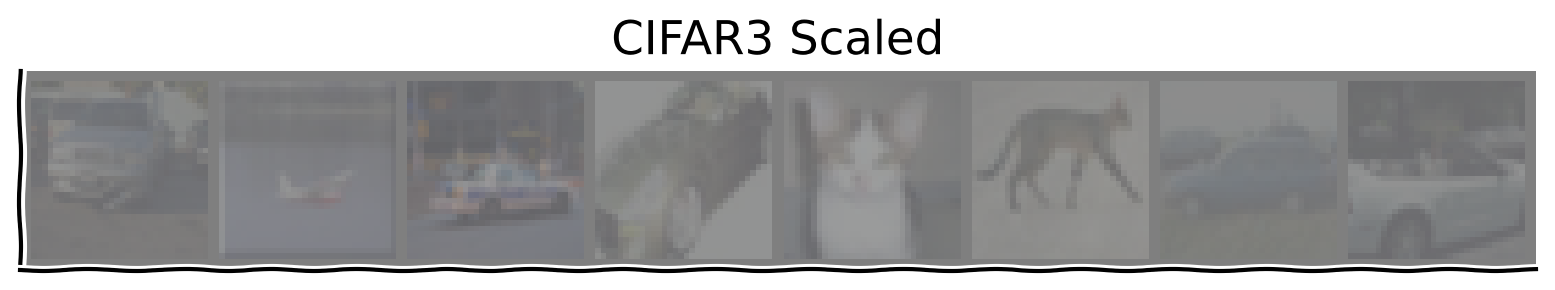

In [65]:
# @title Visualize Images

set_seed(seed=42, seed_torch=True)

num_images_show = 8
cifar_demo_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.49139968, 0.48215827, 0.44653124),
        (0.24703233, 0.24348505, 0.26158768))
    ])

# Demo datasets
cifar10_demo_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar_demo_transform)
cifar3_demo_trainset = CIFAR3(cifar10_demo_trainset, cifar3_classes)
cifar3scaled_demo_trainset = CIFAR3(cifar10_demo_trainset, cifar3_classes, scale=True)

# functions to show an image
def imshow(img, title):
    with plt.xkcd():
        img = (img * 0.25) + 0.5     # unnormalize
        npimg = img.numpy()
        plt.title(title)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.xticks([])
        plt.yticks([])
        plt.show()

# get some random training images
random_idxs = np.random.choice(range(len(cifar3_demo_trainset)), num_images_show)
cifar3_imgs = None
cifar3scaled_imgs = None
cifar3_labels_ = []

for ridx in random_idxs:
    c4img, lbl_ = cifar3_demo_trainset[ridx]
    c4simg, slbl_ = cifar3scaled_demo_trainset[ridx]
    assert lbl_ == slbl_, 'Labels do not match'
    cifar3_labels_.append(lbl_)
    cifar3_imgs = c4img.unsqueeze(0) if (cifar3_imgs is None) else torch.cat((cifar3_imgs, c4img.unsqueeze(0)))
    cifar3scaled_imgs = c4simg.unsqueeze(0) if (cifar3scaled_imgs is None) else torch.cat((cifar3scaled_imgs, c4simg.unsqueeze(0)))

# print labels
print('Labels = ' + ', '.join(f'{cifar10_classes[list(cifar3_classes.keys())[cifar3_labels_[j]]]:5s}' for j in range(num_images_show)))
# show images
imshow(torchvision.utils.make_grid(cifar3_imgs), 'CIFAR3')
# print scaling factor
print('Scaling factors = ' + ', '.join([str(round(i.item(), 3) )for i in cifar3scaled_demo_trainset.scale_values[random_idxs]]))
# show scaled images
imshow(torchvision.utils.make_grid(cifar3scaled_imgs), 'CIFAR3 Scaled')

Here, we define the CNN model with an optional parameter for adding the `LayerNorm` layer.

In [66]:
# @title Define CIFARNet model

set_seed(seed=42, seed_torch=True)

class CIFARNet(nn.Module):
    def __init__(self, layer_norm=False):
        super().__init__()
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 16, 5, padding='same')),
            ('norm1', nn.LayerNorm((16, 8, 8))),
            ('relu1', nn.ReLU()),
            ('maxpool1', nn.MaxPool2d(3, padding=1,  stride=2)),
            ('conv2', nn.Conv2d(16, 32, 3, padding='same')),
            ('norm2', nn.LayerNorm((32, 4, 4))),
            ('relu2', nn.ReLU()),
            ('avgpool2', nn.AvgPool2d(3, padding=1,  stride=2))
        ]))
        if not layer_norm:
            del self.features.norm1
            del self.features.norm2
        self.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(128, 64)),
            ('fc2', nn.Linear(64, 3)),
        ]))
        # Initialize weights
        nn.init.normal_(self.features.conv1.weight, mean=0.0, std=1e-4)
        nn.init.normal_(self.features.conv2.weight, mean=0.0, std=1e-4)
        nn.init.normal_(self.classifier.fc1.weight, mean=0.0, std=1e-1)
        nn.init.normal_(self.classifier.fc2.weight, mean=0.0, std=1e-1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.classifier(x)
        return x

It will take around 3 minutes to complete training on different types of models.

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


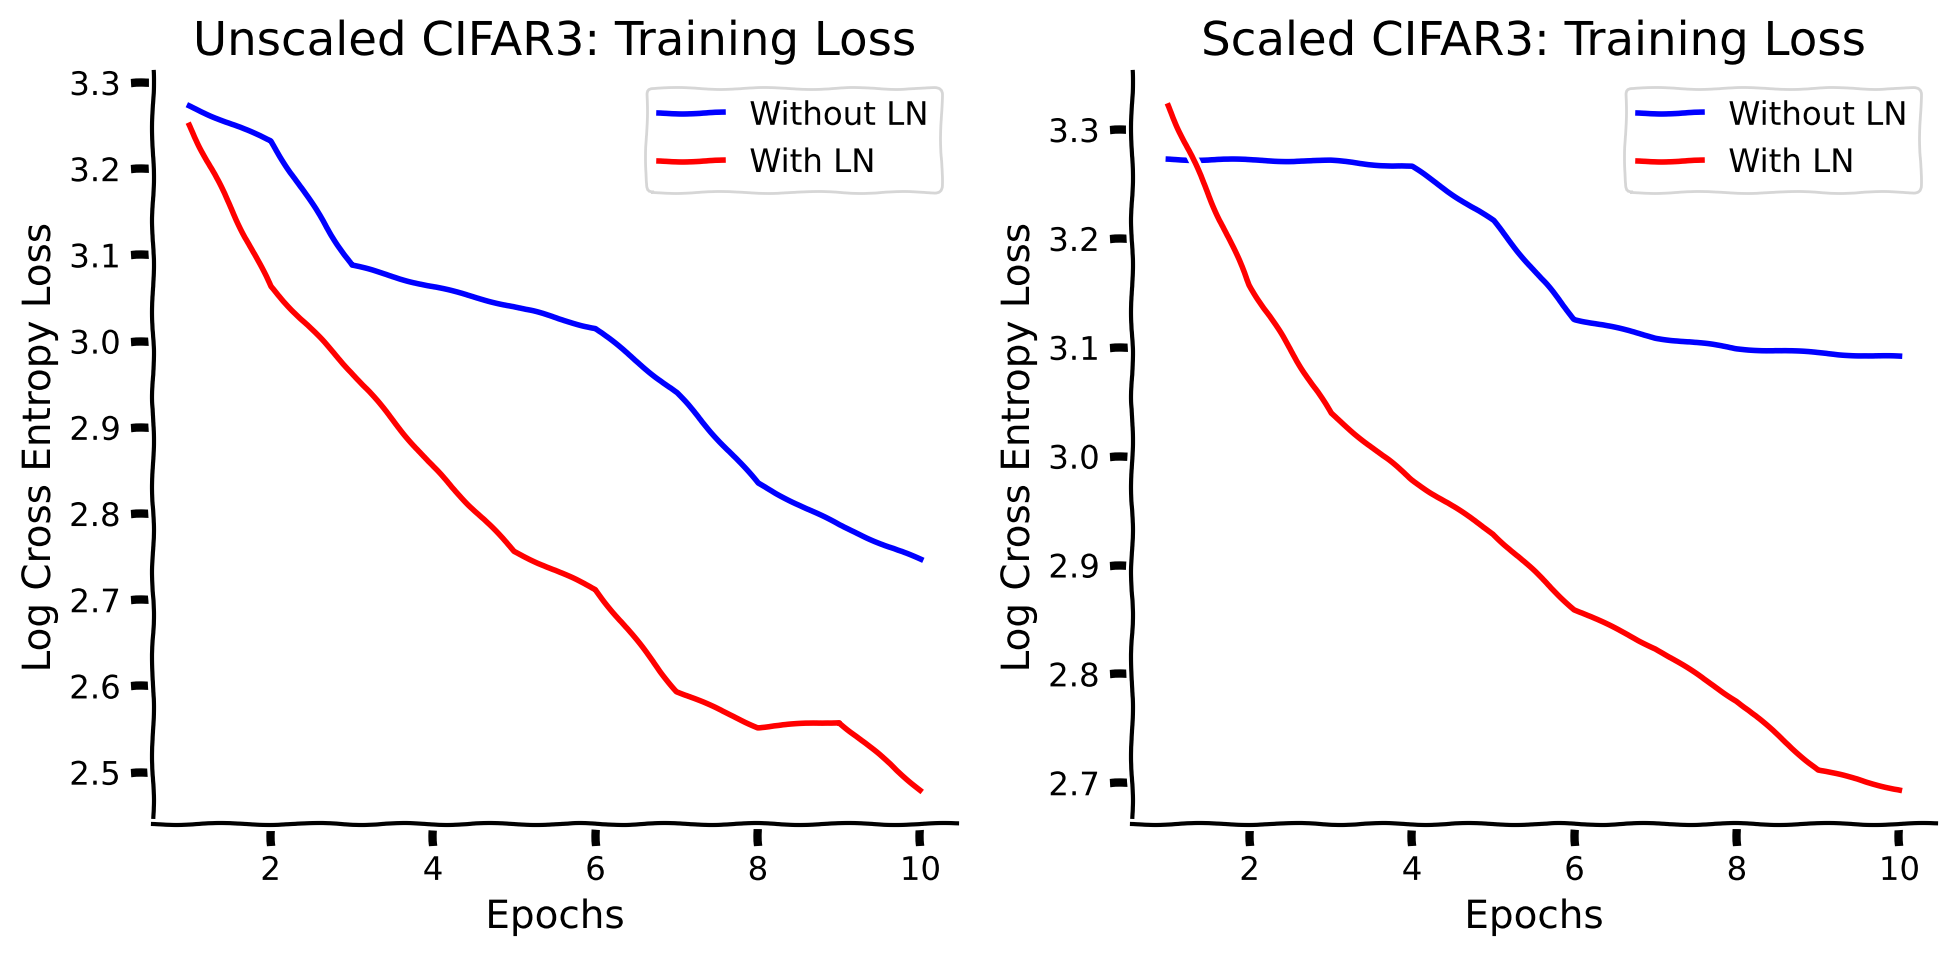

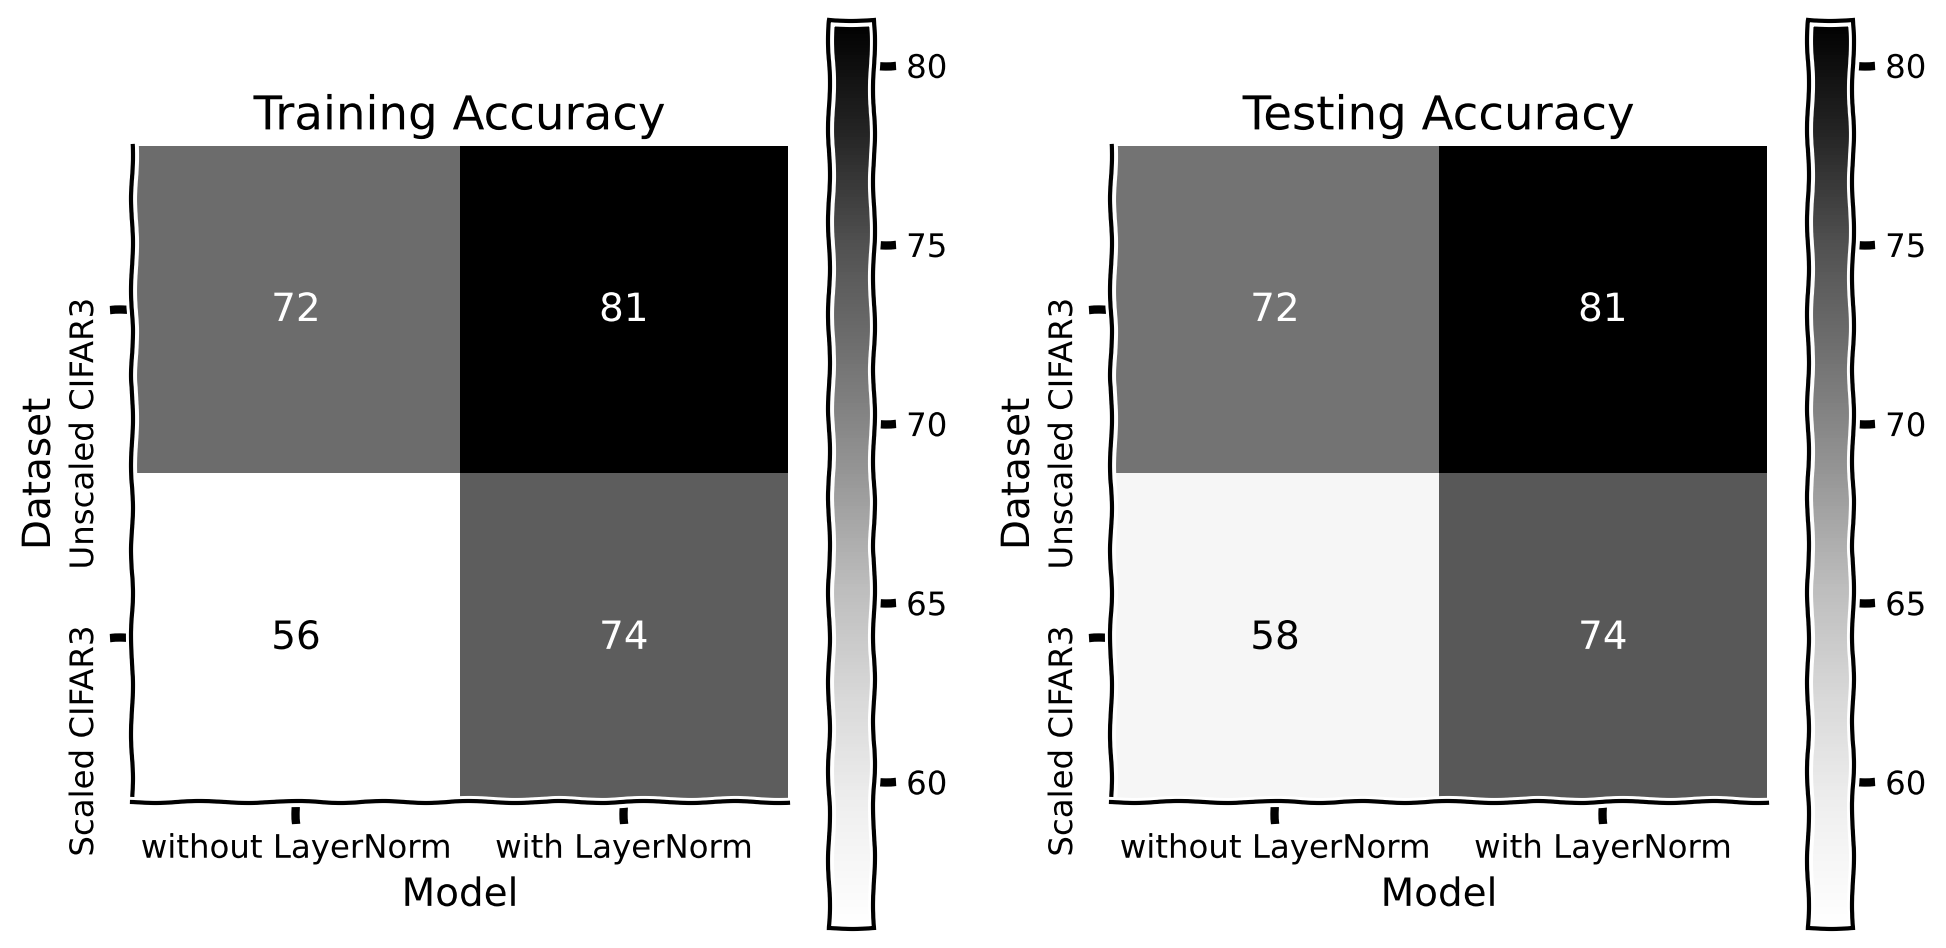

In [67]:
# @title Training & Evaluating the models

# Training
n_epochs = 10
learning_rate = 5e-2
momentum = 0.9

# Unscaled CIFAR3
cifar3_net = CIFARNet(layer_norm=False).to(DEVICE)
losses_iter, losses_epoch = train_cnns(cifar3_net, cifar3_trainloader, \
                                  learning_rate, momentum, n_epochs)
# With LayerNorm
cifar3_net_LN = CIFARNet(layer_norm=True).to(DEVICE)
losses_iter_LN, losses_epoch_LN = train_cnns(cifar3_net_LN, cifar3_trainloader, \
                                  learning_rate, momentum, n_epochs)

# Scaled CIFAR3
cifar3scaled_net = CIFARNet(layer_norm=False).to(DEVICE)
losses_iter_scaled, losses_epoch_scaled = train_cnns(cifar3scaled_net, cifar3scaled_trainloader, \
                                  learning_rate, momentum, n_epochs)
# With LayerNorm
cifar3scaled_net_LN = CIFARNet(layer_norm=True).to(DEVICE)
losses_iter_scaled_LN, losses_epoch_scaled_LN = train_cnns(cifar3scaled_net_LN, cifar3scaled_trainloader, \
                                  learning_rate, momentum, n_epochs)

with plt.xkcd():
    # Plot training losses
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot 1 - Unscaled CIFAR3
    # Plot loss per epoch
    ax[0].plot(range(1, len(losses_epoch)+1), np.log(losses_epoch), '-b', label='Without LN')
    ax[0].plot(range(1, len(losses_epoch_LN)+1), np.log(losses_epoch_LN), '-r', label='With LN')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Log Cross Entropy Loss')
    ax[0].set_title('Unscaled CIFAR3: Training Loss')

    # Plot 2 - Scaled CIFAR3
    # Plot loss per epoch
    ax[1].plot(range(1, len(losses_epoch_scaled)+1), np.log(losses_epoch_scaled), '-b', label='Without LN')
    ax[1].plot(range(1, len(losses_epoch_scaled_LN)+1), np.log(losses_epoch_scaled_LN), '-r', label='With LN')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Log Cross Entropy Loss')
    ax[1].set_title('Scaled CIFAR3: Training Loss')

    plt.tight_layout()
    plt.show()

# Training evaluation
training_loss, training_accuracy = evaluate_cnns(cifar3_net, cifar3_trainloader)
training_loss_LN, training_accuracy_LN = evaluate_cnns(cifar3_net_LN, cifar3_trainloader)
training_loss_scaled, training_accuracy_scaled = evaluate_cnns(cifar3scaled_net, cifar3scaled_trainloader)
training_loss_scaled_LN, training_accuracy_scaled_LN = evaluate_cnns(cifar3scaled_net_LN, cifar3scaled_trainloader)

# Evaluation
test_loss, test_accuracy = evaluate_cnns(cifar3_net, cifar3_testloader)
test_loss_LN, test_accuracy_LN = evaluate_cnns(cifar3_net_LN, cifar3_testloader)
test_loss_scaled, test_accuracy_scaled = evaluate_cnns(cifar3scaled_net, cifar3scaled_testloader)
test_loss_scaled_LN, test_accuracy_scaled_LN = evaluate_cnns(cifar3scaled_net_LN, cifar3scaled_testloader)

with plt.xkcd():
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    training_cm = [[training_accuracy, training_accuracy_LN], [training_accuracy_scaled, training_accuracy_scaled_LN]]
    testing_cm = [[test_accuracy, test_accuracy_LN], [test_accuracy_scaled, test_accuracy_scaled_LN]]
    all_cm = np.array(training_cm+training_cm).flatten()
    vmin = np.min(all_cm)
    vmax = np.max(all_cm)

    training_disp = ConfusionMatrixDisplay(confusion_matrix=np.array(training_cm),
                                   display_labels=['Unscaled CIFAR3', 'Scaled CIFAR3'])
    training_disp.plot(cmap=plt.cm.Greys, ax=axs[0])
    axs[0].images[-1].set_clim(vmin, vmax)
    axs[0].set_yticks([0, 1], ['Unscaled CIFAR3', 'Scaled CIFAR3'], rotation=90)
    axs[0].set_xticks([0, 1], ['without LayerNorm', 'with LayerNorm'])
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Dataset')
    axs[0].set_title('Training Accuracy')

    testing_disp = ConfusionMatrixDisplay(confusion_matrix=np.array(testing_cm),
                                   display_labels=['Unscaled CIFAR3', 'Scaled CIFAR3'])
    testing_disp.plot(cmap=plt.cm.Greys, ax=axs[1])
    axs[1].images[-1].set_clim(vmin, vmax)
    axs[1].set_yticks([0, 1], ['Unscaled CIFAR3', 'Scaled CIFAR3'], rotation=90)
    axs[1].set_xticks([0, 1], ['without LayerNorm', 'with LayerNorm'])
    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('Dataset')
    axs[1].set_title('Testing Accuracy')
    plt.tight_layout()
    # Removing shadows from text inside confusion matrix
    for txt in training_disp.text_.flatten():
      txt.set_path_effects([path_effects.Normal()])
    for txt in testing_disp.text_.flatten():
      txt.set_path_effects([path_effects.Normal()])
    plt.show()

Let us also check whether normalization improves generalization with different scaling parameters.

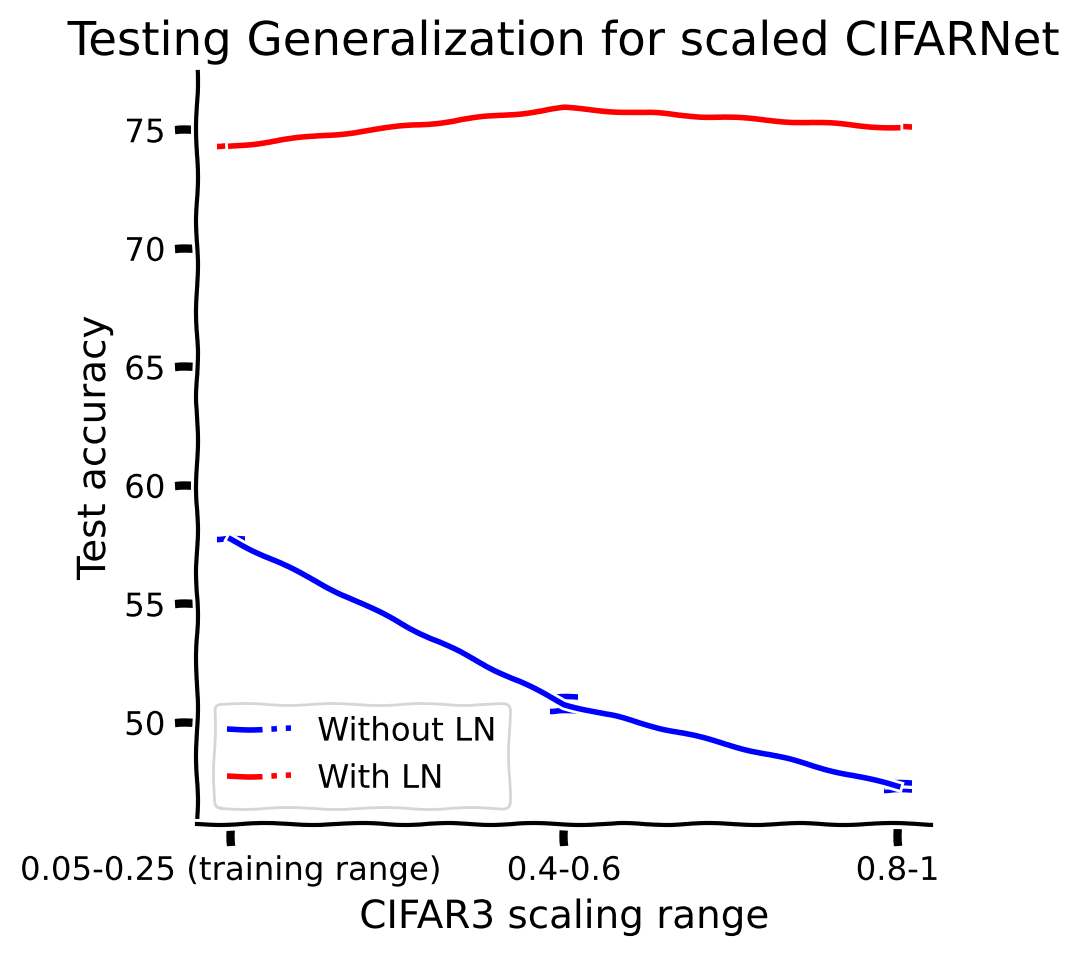

In [68]:
# @title Test Generalization

n_tests = 5

cifar3_scaling_performances = {}
cifar3_scaling_performances_LN = {}

# scaling_limits_tests = [[0.3, 0.5], [0.5, 0.75], [0.75, 1]]
scaling_limits_tests = [[0.4, 0.6], [0.8, 1]]

for test_idx in range(n_tests):
  cifar3_scaled_testloaders = {
    '0.05-0.25 (training range)': cifar3scaled_testloader
  }

  for sc_ in scaling_limits_tests:
    sc_str = '-'.join([str(i) for i in sc_])
    testset_ = CIFAR3(cifar10_testset, cifar3_classes, scale=True, scaling_limits=sc_)
    testloader_ = torch.utils.data.DataLoader(testset_, batch_size=batch_size,
                                          shuffle=False)
    cifar3_scaled_testloaders[sc_str] = testloader_

  for scaling_lims, scaling_testloader in cifar3_scaled_testloaders.items():
    _, noLN_accuracy = evaluate_cnns(cifar3scaled_net, scaling_testloader)
    _, LN_accuracy = evaluate_cnns(cifar3scaled_net_LN, scaling_testloader)
    if scaling_lims in cifar3_scaling_performances.keys():
      cifar3_scaling_performances[scaling_lims] += [noLN_accuracy]
      cifar3_scaling_performances_LN[scaling_lims] += [LN_accuracy]
    else:
      cifar3_scaling_performances[scaling_lims] = [noLN_accuracy]
      cifar3_scaling_performances_LN[scaling_lims] = [LN_accuracy]

with plt.xkcd():
    plt.figure(figsize=(5, 5))
    mean_cifar3_scaling_performances = [np.mean(i) for i in cifar3_scaling_performances.values()]
    std_cifar3_scaling_performances = [np.std(i) for i in cifar3_scaling_performances.values()]
    plt.plot(range(1, len(cifar3_scaled_testloaders)+1), mean_cifar3_scaling_performances, \
             '-.b', label='Without LN')
    plt.errorbar(range(1, len(cifar3_scaled_testloaders)+1), mean_cifar3_scaling_performances, \
             yerr=std_cifar3_scaling_performances, color='b', capsize=5, capthick=2)
    mean_cifar3_scaling_performances_LN = [np.mean(i) for i in cifar3_scaling_performances_LN.values()]
    std_cifar3_scaling_performances_LN = [np.std(i) for i in cifar3_scaling_performances_LN.values()]
    plt.plot(range(1, len(cifar3_scaled_testloaders)+1), mean_cifar3_scaling_performances_LN, \
             '-.r', label='With LN')
    plt.errorbar(range(1, len(cifar3_scaled_testloaders)+1), mean_cifar3_scaling_performances_LN, \
             yerr=std_cifar3_scaling_performances_LN, color='r', capsize=5, capthick=2)
    plt.xticks(range(1, len(cifar3_scaled_testloaders)+1), labels=cifar3_scaled_testloaders.keys())
    plt.xlabel('CIFAR3 scaling range')
    plt.ylabel('Test accuracy')
    plt.title('Testing Generalization for scaled CIFARNet')
    plt.legend()
    plt.show()

By adding a normalization layer: (i) the training process converges quicker, (ii) we achieve better test accuracy and (iii) we achieve better out-of-distribution generalization accuracy in the image recognition tasks.

In [69]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_layer_normalization_example")

In [ ]:
# @title Video 8: Section summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', '2ME2uKnRisw'), ('Bilibili', 'BV1zw4m1Y7W4')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_last_section_summary")

---
# Summary

*Estimated timing of tutorial: 50 minutes*

In this tutorial, we observed that normalization as an inductive bias is useful. We have implemented the normalization function and explored the examples. Finally, we discovered the benefits of using normalization.

In [ ]:
# @title Video 9: Tutorial summary

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents

video_ids = [('Youtube', 'gsMsRPWLJj8'), ('Bilibili', 'BV15z421b7uf')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_tutorial_summary")

# The Big Picture

In this tutorial, we observed that normalization as an inductive bias is useful. We first showed that models struggle to learn the normalization function and it makes sense computationally to implement this operation as a dedicated microcircuit, our topic of the day! We further showed the effect that normalization has on efficient model training and how it enables out-of-distribution accuracy by stabilizing the training process and recovering images that had been corrupted by scaling.

We ended by looking at how normalization processes occur in brains and we prompt you to think whether any of the computational advantages in neural networks might perform similar functions in the brain. Are there things we can learn and apply to studying brains? Perhaps further work in normalization in neuroscience might end up introducing variations of brain-inspired normalization into neural networks, which could help the model learn even better!